# Gromore basic domain
## Model Description before GroMore proposal 
This is a steady state box model with recharge and ET. An additional layer was also added to the model.

#### Dimensions: 
- 50 by 50 by 1
- dx = dy = 1000 m
- dz = varied 
- three layers

#### Topography
- Top layer elevation given in csv file
- Middle layer is flat and 5m thick
- Bottom layer (Layer 3) is flat and 40m thick

#### Subsurface Properties: 
- Porosity = 0.1
- Specific yield = 0.1
- Storage coefficient=0.0001 
- Homogeneous in each layer
##### Layers
 - Layer 1 = Layer 3
     - Kx=Ky=Kz= 10m/d
 - Layer 2 
     - 20 leftmost columns, Kx=Ky=Kz= 10m/d
     - Other columns, Kz= 0.0001m/d

#### Boundary Conditions: 
 - Right boundary is a constant head of 70 m relative to datum for all layers (datum is at bottom of domain)
 - All other boundaries are no flow
 - Top left corner: no flow
     - Extends from row 45, column 1 to row 50, column 6, inclusive, comprising a total of 21 no flow cells
 - A symmetric no flow region exists in the bottom left corner
     - row 41, column 1 to row 50, column 10.
 - Middle layer has no flow regions
     - Extends from row 43, column 1 to row 50, column 8 
 
#### ET: 
- Zero in left half
- 1E-5 m/day in the right half of the domain
- Riparian zone
    - Extends from left to right boundary of rows 23 to 29, inclusive
    - Rate: 5E-5m/d
- Extinction depth= 10m
 
#### Recharge: 
 - Leftmost 15 columns at a rate of 4E-5 m/d
 - Zero everywhere else

#### Stream:
- Begins in left boundary and goes to the right in row 26
- width=length=thickness= 1.0
- No flow is entering the stream
- streambed
    - K= 1000m/d
    - elevation= 1.0m below ground surface
    - stage= 0.5m
- "weak sink" with strength 0.5 (This is set under MODPATH/Particle Options.)
 
#### Well: 
 - Pumping well for Aquaseca
     - Completed in bottom layer
     - Located at row 21, column 38
     - Pumping at a rate of 1500 m^3/day 

## Model Description after GroMore proposal 

#### Ag field:
- cover a 2000m by 2000m area
- 1/8th of the area will be irrigated agriculture at any time (the field area is multiplied by 0.125). 
- Rectangular irrigated fields extend between rows 21 and 22 (inclusive) and columns 19 and 20 (inclusive).

##### ET
- ET for the crop is zero - it is accounted for in the calculated recharge 

##### Recharge
- Rate is 20% of the water demand of the crop, representing intentional excess irrigation to avoid soil salinization
- Crop water uses/recharge rates:
    - Wheat= 0.004m/d / 0.0001m/d
    - Pistachios= 0.006m/d / 0.00015m/d
    - Cotton: 0.008 m/d / 0.0002 m/d
    
##### Pumping Well:
- Completed in top layer
- Row 12 and column 14
- Pumping rate equal to the crop water demand plus 20% for excess irrigation plus 30% for irrigation inefficiency
    - Wheat= 3000 m3/day
    - Pistachos= 4500 m3/d
    - Cotton= 6000 m3/d
    
##### Monitoring wells
- Two monitoring in transient conditions
    - One at [25000, 25000] 
    - Other at [12500, 12500].

*For simplicity, we will consider a year to be comprised of 12 30-day months.

## 1. Import packages

In [1]:
#import packages
import flopy
import numpy as np
import matplotlib as mp
import os
import flopy.utils.binaryfile as bf
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import csv

#print full output
np.set_printoptions(threshold=np.inf)

#jupyter specific--included to show plots in notebook
%matplotlib inline 

#Delete Packages
dir = "/Users/amanda_triplett/Documents/Courses/groundwater_Modeling/GroMore_Project/amanda/scenario2"
files = os.listdir(dir)
ext=['.dis','.bas','.lpf','.oc','.pcg','.wel','.hds','.cbc','.riv','.list','.nam','.evt',
     '.rch','.mpbas','.mpend','.mplst','.mpnam','.mppth','.mpsim','.log','.timeseries',
     '.lis','.chd','.ddn','.sloc']
for file in files:
    for i in range(0,len(ext)):
        if file.endswith(ext[i]):
            os.remove(os.path.join(dir,file))

flopy is installed in /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/flopy


In [2]:
print(len(ext))

25


## 2. Discretization and other inputs

In [3]:
# Discretization
nrow = 50 #number of rows
ncol = 50 #number of columns
nlay = 3  #number of layers

dx= 1000 #width of grid cells in x direction 
dy= 1000 #width of grid cells in y direction 
Lx = ncol*dx  #width of domain in x
Ly = nrow*dy #width of domain in y

ztop = np.genfromtxt('base_model_elevs.csv', delimiter=',', dtype=float)   # top elevation of top layer (import from csv file) (dim: nrow,ncol)

## Subsurface properties
n = 0.1        #assign porosity
Ss = 0.0001      #assign storage coefficient
Sy = 0.1        #assign specific yield
uncnf = 1       #0=confined, >0 = unconfined

## ET
ET = 1e-5 #m/day
ET_locxy=[[24000,0], [0, 0]] #lower left and upper right corners of ET in xy coordinate
ET_rows_forced=(1.0, 49.0) #me forcing the et_rows to be 0-50
ET_cols_forced = (26.0, 49.0)
ET_zone = np.zeros((1,nrow,ncol))     # define an array of zeroes the size of the model grid
ET_zone[0,int(ET_rows_forced[0]):int(ET_rows_forced[1]), int(ET_cols_forced[0]):int(ET_cols_forced[1])] = ET 

rip_ET= 5e-5  #riparian zone
rip_locxy= [[0,21000],[23000,0]]
rip_rows_forced = (21.0, 28.0)  #forced riparian area
rip_cols_forced = (1.0, 49.0)
rip_zone = np.zeros((nlay,nrow,ncol))     # define an array of zeroes the size of the model grid
ET_zone[0,int(rip_rows_forced[0]):int(rip_rows_forced[1]), int(rip_cols_forced[0]):int(rip_cols_forced[1])] = rip_ET 

extinction_depth = 10 #m

## Recharge
rech=4e-5  #m/d
rechxy=[(0,0),(0,36000)]  #recharge zone

rech_rows_forced = (1.0, 49.0) #rech zone forced for leftmost 15 cols
rech_cols_forced = (1.0, 15.0)

rech_zone = np.zeros((1,nrow,ncol))
rech_zone[0,int(rech_rows_forced[0]):int(rech_rows_forced[1]),int(rech_cols_forced[0]):int(rech_cols_forced[1])]=rech
#print("recharge location forced(col, row)", rech_cols_forced,rech_rows_forced)

# Setting up wells
pumping1 = 0 # m3/day      -1500 pumping rate for water supply well  
pumping2 = 0 # m^3/d         -3000 irrigation well pumping rate (for wheat)

well_agua = [2,29,37, pumping1] #Well loc (layer, row, column)
well_ag = [0,38,12, pumping2] #Well loc (layer, row, column)
MW1 = [0,25,24,0]
MW2 = [0,37,12,0]

wel_spd = {0: [well_agua, well_ag, MW1, MW2]}

## init boundary conditions
h_right = 70

## Timing
# nper = 1 #number of stress periods 
# steady = [True] #list noting the stress period type

### Layering

In [4]:
## define layer properties 
K_horiz = 10 #m/d
K_vert = 10 #m/d
K_vert2 = 0.0001 #m/d  #K for the middle layer 


## make horizontal K np arrays
Kh = np.zeros((nlay,nrow,ncol))     # define an array of zeros the size of the model grid (nlay, nrow, ncol)
Kh[:,:,:] = K_horiz # assign the original value to the entire array

## Make a arrays for the K values
Kz = np.zeros((nlay,nrow,ncol))     # define an array of zeros the size of the model grid (nlay, nrow, ncol)
Kz[:,:,:] = K_vert                   # assign the original value to the entire array
Kz[1,:,20:49] = K_vert2            #Replace K in the middle layer with the lower value
#Kz[1,:,:] = K_vert2
#print(K_horiz)
#print(Kz)

## Make some changes to the parameters
bot_elev = 0.
mid_elev = 40.
top_elev = 45.

botm = np.zeros((nlay,nrow,ncol)) # initialize array of zeros for bottom elevation for each model cell (dim: nlay,nrow,ncol)
botm[2,:,:] = bot_elev                 # bottom elevation of lowest layer (2) is 0 m
botm[1,:,:] = mid_elev                 #bottom elevation of middle layer (1) is 40 m           
botm[0,:,:] = top_elev                 # bottom elevation of top layer (0) 45 

## Boundary Conditions

In [5]:
#setup initial heads as 1 everywhere except on the boundaries
H_init = np.ones((nlay, nrow, ncol), dtype=np.float32)  #float array (i.e. decimal), sets all heads to 1.0
H_init[:, :, :] = h_right  #initialize the entire domain to the right head value
H_init[:, :, 49] = h_right    #replace first (right) col with desired head value
#########################

#Define cell activity (IBOUND)
ibound=np.ones((nlay,nrow,ncol))                                                  
ibound[:,:,0] = 0  #1st col = no flow       
ibound[:,:,49] = -1  #last col = constant head 

ibound[:,0,:49]=0
ibound[:,49,:49]=0
ibound[:,1,:5]=0
ibound[:,2,:4]=0
ibound[:,3,:3]=0
ibound[:,4,:2]=0

ibound[:,48,:5]=0
ibound[:,47,:4]=0
ibound[:,46,:3]=0
ibound[:,45,:2]=0

ibound[1:,1,:7]=0
ibound[1:,2,:6]=0
ibound[1:,3,:5]=0
ibound[1:,4,:4]=0
ibound[1:,5,:3]=0
ibound[1:,6,1]=0

ibound[1:,48,:7]=0
ibound[1:,47,:6]=0
ibound[1:,46,:5]=0
ibound[1:,45,:4]=0
ibound[1:,44,:3]=0
ibound[1:,43,1]=0

ibound[2,1,:9]=0
ibound[2,2,:8]=0
ibound[2,3,:7]=0
ibound[2,4,:6]=0
ibound[2,5,:5]=0
ibound[2,6,:4]=0
ibound[2,7,:3]=0
ibound[2,8,1]=0

ibound[2,48,:9]=0
ibound[2,47,:8]=0
ibound[2,46,:7]=0
ibound[2,45,:6]=0
ibound[2,44,:5]=0
ibound[2,43,:4]=0
ibound[2,42,:3]=0
ibound[2,41,1]=0


np.set_printoptions(threshold=np.inf)

## River properties

In [6]:
#DEFINE RIVERS
riv_row= 24
riv_sp = [] #create list to store all river cells for stress period 1
k_rivbott = 1000 #river bottom hydraulic conductivity in m/d
sed_thick = 1 #thickness of riverbed sediment in m
#cond = k_rivbott*(1)*(1)/(sed_thick) #river bed conductance in m^2/d
cond = k_rivbott*(1)*(1000)/(sed_thick) #river bed conductance in m^2/d
r_stage = .5 #stage in river (stress period 1)
r_bott = ztop[riv_row,:] #river bottom
#print(r_bott)
for i in range(1,ncol):
    riv_sp.append([0, riv_row, i, r_bott[i]-1+sed_thick+r_stage, cond, r_bott[i]-2])
    
#print(riv_spd)
#create dictionary of stress period data
riv_spd = {0: riv_sp}
#print(riv_spd[0])

# Run Scenario 2 - Predevelopment Seasonality

Build the base model as described above without proposed agricultural activity 

Run the model as transient for 25 years with no pumping from the town's well. Recharge occurs at a constant rate all year, but ET takes place from April through September (inclusive) at the rate given in the problem description.

How long does it take for the model to reach a cyclical steady state (annual variations, but no trends)? Use monthly water levels at the monitoring wells to support your conclusion. This is the required 'burn in' time of your model.

### Setting up seasonality


In [7]:
#We start in October, because that's a water year
sp_peryr = 2        # periods for seasonality (two stress periods per year)
sp1_len = 180       # Length of stress period 1 in days, October-March, no ET
sp2_len = 180      # Length of stress period 2 in days. April - September, regular ET
sim_years = 200       #number of years for transient simulation 
nper = int(sp_peryr*sim_years + 1)
print (nper)

#setup the steady state array
steady = np.ones(nper, dtype=bool)*False # transient flag is false
steady[0] = True    # initial stress period is steady-state or true
#print(steady)

#make an array of period lengths
perlen=np.tile([sp1_len, sp2_len],sim_years)#100 repeating sets of the two stress periods
perlen=np.append(10,perlen) #add a period of length 10 at the start for the steady state simulation
print("Period lengths", perlen)

#make an nstp array for the # of time steps to solve within each period in this case we will do daily 
#so we can repeat the perlen array
nstp=perlen #can't divide, won't meet convergence criteria
nstp[0]=1 #for the steady state solution we just want one output
#nstp = nstp.astype(int) #changes from float to int after dividing
print("Number of Steps", nstp)

401
Period lengths [ 10 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180
 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180
 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180
 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180
 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180
 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180
 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180
 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180
 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180
 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180
 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180
 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180
 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180
 180 180 180 180 180 180 180 180

### Setting up seasonal ET

In [8]:
#Setup alternating ET values
#ET_zone has the seasonal ET values
                      
ET_dict = {} #set up an ET dictionary, where each key is a stress period num 0-50
ET_zone2 = ET_zone * 0 
for p in range(0,nper):    #loop over stress periods, odds are 0 ET, evens are reg ET
    if p == 0:
        ET_dict[p] = ET_zone
    elif int(p % 2) != 0:
        ET_dict[p]=ET_zone2
        #print(p)
    else: 
        ET_dict[p] = ET_zone

## Set up and run scenario 2

In [9]:
#Initialize the model
modelname = "Scenario_2"
#moddir="/Users/hardknox47/Desktop/HWRS482/MODFLOW/pymake/examples/mf2005"
moddir="/Users/amanda_triplett/Documents/Courses/groundwater_Modeling/pymake/examples/mf2005"
m = flopy.modflow.Modflow(modelname, exe_name = moddir)

#Discretization - dis
dis = flopy.modflow.ModflowDis(model=m, nlay=nlay, nrow=nrow, ncol=ncol, 
                               delr=dx, delc=dy, top=ztop, botm=botm, 
                               itmuni = 4, lenuni = 2, 
                               nper=nper, steady=steady, perlen=perlen, nstp = nstp)

# Boundary and initial conditions - bas
bas = flopy.modflow.ModflowBas(m, ibound=ibound, strt=H_init)

#Layer properties - lpf
lpf = flopy.modflow.ModflowLpf(m, laytyp=uncnf, hk=Kh, 
                               vka=Kz, ss=Ss,
                               sy=Sy,storagecoefficient=True, ipakcb=53)

rch = flopy.modflow.mfrch.ModflowRch(model=m, rech=rech_zone, ipakcb=53)     #create rch object


# Attach ET package
evt = flopy.modflow.mfevt.ModflowEvt(m, surf=ztop, evtr=ET_dict, exdp=extinction_depth, ipakcb=53) 

wel = flopy.modflow.ModflowWel(model=m, stress_period_data=wel_spd)

#Setting up RIV package
riv = flopy.modflow.ModflowRiv(model=m,stress_period_data = riv_spd, ipakcb=53)

#Output control - OC 
oc_spd = {}
for kper in range(1,nper): #nper is 201, this is the key for each entry in oc_spd dict
    oc_spd[(kper, 179)] = ['save head','save drawdown','save budget','print head','print budget']
#will save the data from the last day in each stress period
#print(np.shape(oc_spd))
oc = flopy.modflow.ModflowOc(model=m, stress_period_data=oc_spd, compact=True)

#Numerical solver - pcg
#pcg = flopy.modflow.ModflowPcg(model=m)
#Numerical solver - pcg
pcg = flopy.modflow.ModflowPcg(model=m, mxiter=100, iter1=200, relax = 0.97, damp = 0.9)

#write the inputs
m.write_input()   
m.evt.check()
m.oc.check()
m.oc.check()
m.lpf.check()
m.pcg.check()
m.riv.check()
m.rch.check()
m.dis.check()
  

#Run the model 
success, mfoutput = m.run_model(pause=False, report=True)
if not success:
    raise Exception('MODFLOW did not terminate normally.')

check method not implemented for EVT Package.

OC PACKAGE DATA VALIDATION:
  No errors or warnings encountered.


OC PACKAGE DATA VALIDATION:
  No errors or warnings encountered.


LPF PACKAGE DATA VALIDATION:
  1 Warning:
    STORAGECOEFFICIENT option is activated, storage values are read storage coefficients

  Checks that passed:
    zero or negative horizontal hydraulic conductivity values
    zero or negative vertical hydraulic conductivity values
    negative horizontal anisotropy values
    horizontal hydraulic conductivity values below checker threshold of 1e-11
    horizontal hydraulic conductivity values above checker threshold of 100000.0
    vertical hydraulic conductivity values below checker threshold of 1e-11
    vertical hydraulic conductivity values above checker threshold of 100000.0
    zero or negative specific storage values
    specific storage values below checker threshold of 1e-06
    specific storage values above checker threshold of 0.01
    zero or negative 

 Solving:  Stress period:     2    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:    90    Ground-Wa

 Solving:  Stress period:     3    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:    22    Ground-Wa

 Solving:  Stress period:     3    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:   140    Ground-Wa

 Solving:  Stress period:     4    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    78    Ground-Wa

 Solving:  Stress period:     5    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    15    Ground-Wa

 Solving:  Stress period:     5    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:   133    Ground-Wa

 Solving:  Stress period:     6    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:    72    Ground-Wa

 Solving:  Stress period:     6    Time step:   180    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:    12    Ground-Wa

 Solving:  Stress period:     7    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:   121    Ground-Wa

 Solving:  Stress period:     8    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:    54    Ground-Wa

 Solving:  Stress period:     8    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:   170    Ground-Wa

 Solving:  Stress period:     9    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:   101    Ground-Wa

 Solving:  Stress period:    10    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:    39    Ground-Wa

 Solving:  Stress period:    10    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:   153    Ground-Wa

 Solving:  Stress period:    11    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:    85    Ground-Wa

 Solving:  Stress period:    12    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:    27    Ground-Wa

 Solving:  Stress period:    12    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:   143    Ground-Wa

 Solving:  Stress period:    13    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:    80    Ground-Wa

 Solving:  Stress period:    14    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:    25    Ground-Wa

 Solving:  Stress period:    14    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:   140    Ground-Wa

 Solving:  Stress period:    15    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:    71    Ground-Wa

 Solving:  Stress period:    16    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:    16    Ground-Wa

 Solving:  Stress period:    16    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:   124    Ground-Wa

 Solving:  Stress period:    17    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:    56    Ground-Wa

 Solving:  Stress period:    17    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:   178    Ground-Wa

 Solving:  Stress period:    18    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:   109    Ground-Wa

 Solving:  Stress period:    19    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:    45    Ground-Wa

 Solving:  Stress period:    19    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:   170    Ground-Wa

 Solving:  Stress period:    20    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:   102    Ground-Wa

 Solving:  Stress period:    21    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:    41    Ground-Wa

 Solving:  Stress period:    21    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:   161    Ground-Wa

 Solving:  Stress period:    22    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:    93    Ground-Wa

 Solving:  Stress period:    23    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:    30    Ground-Wa

 Solving:  Stress period:    23    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:   152    Ground-Wa

 Solving:  Stress period:    24    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:    87    Ground-Wa

 Solving:  Stress period:    25    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:    27    Ground-Wa

 Solving:  Stress period:    25    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:   149    Ground-Wa

 Solving:  Stress period:    26    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:    87    Ground-Wa

 Solving:  Stress period:    27    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:    24    Ground-Wa

 Solving:  Stress period:    27    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:   141    Ground-Wa

 Solving:  Stress period:    28    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:    78    Ground-Wa

 Solving:  Stress period:    29    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:    17    Ground-Wa

 Solving:  Stress period:    29    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:   134    Ground-Wa

 Solving:  Stress period:    30    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:    70    Ground-Wa

 Solving:  Stress period:    31    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:    14    Ground-Wa

 Solving:  Stress period:    31    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:   125    Ground-Wa

 Solving:  Stress period:    32    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:    59    Ground-Wa

 Solving:  Stress period:    32    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:   177    Ground-Wa

 Solving:  Stress period:    33    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:   108    Ground-Wa

 Solving:  Stress period:    34    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:    50    Ground-Wa

 Solving:  Stress period:    34    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:   171    Ground-Wa

 Solving:  Stress period:    35    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:    98    Ground-Wa

 Solving:  Stress period:    36    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:    37    Ground-Wa

 Solving:  Stress period:    36    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:   152    Ground-Wa

 Solving:  Stress period:    37    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:    85    Ground-Wa

 Solving:  Stress period:    38    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:    28    Ground-Wa

 Solving:  Stress period:    38    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:   145    Ground-Wa

 Solving:  Stress period:    39    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:    79    Ground-Wa

 Solving:  Stress period:    40    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:    20    Ground-Wa

 Solving:  Stress period:    40    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:   130    Ground-Wa

 Solving:  Stress period:    41    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:    41    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:    41    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:    41    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:    41    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:    41    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:    41    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:    41    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:    41    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:    41    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:    41    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:    41    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:    41    Time step:    64    Ground-Wa

 Solving:  Stress period:    41    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:    41    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:    41    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:    41    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:    41    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:    41    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:    41    Time step:   180    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:     6    Ground-Wa

 Solving:  Stress period:    42    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:   114    Ground-Wa

 Solving:  Stress period:    43    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:    47    Ground-Wa

 Solving:  Stress period:    43    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:   172    Ground-Wa

 Solving:  Stress period:    44    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:   101    Ground-Wa

 Solving:  Stress period:    45    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:    37    Ground-Wa

 Solving:  Stress period:    45    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:   153    Ground-Wa

 Solving:  Stress period:    46    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:    87    Ground-Wa

 Solving:  Stress period:    47    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:    28    Ground-Wa

 Solving:  Stress period:    47    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:   147    Ground-Wa

 Solving:  Stress period:    48    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:    81    Ground-Wa

 Solving:  Stress period:    49    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:    18    Ground-Wa

 Solving:  Stress period:    49    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:   137    Ground-Wa

 Solving:  Stress period:    50    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:    50    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:    50    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:    50    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:    50    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:    50    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:    50    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:    50    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:    50    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:    50    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:    50    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:    50    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:    50    Time step:    75    Ground-Wa

 Solving:  Stress period:    51    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:    16    Ground-Wa

 Solving:  Stress period:    51    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:   134    Ground-Wa

 Solving:  Stress period:    52    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:    52    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:    52    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:    52    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:    52    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:    52    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:    52    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:    52    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:    52    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:    52    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:    52    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:    52    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:    52    Time step:    73    Ground-Wa

 Solving:  Stress period:    53    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    53    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    53    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    53    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    53    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    53    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    53    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    53    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    53    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    53    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    53    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:    53    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:    53    Time step:    15    Ground-Wa

 Solving:  Stress period:    53    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:    53    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:    53    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:    53    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:    53    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:    53    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:    53    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:    53    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:    53    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:    53    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:    53    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:    53    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:    53    Time step:   132    Ground-Wa

 Solving:  Stress period:    54    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:    54    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:    54    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:    54    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:    54    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:    54    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:    54    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:    54    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:    54    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:    54    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:    54    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:    54    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:    54    Time step:    71    Ground-Wa

 Solving:  Stress period:    55    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    55    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    55    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    55    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    55    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    55    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    55    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    55    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    55    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    55    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    55    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    55    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:    55    Time step:    14    Ground-Wa

 Solving:  Stress period:    55    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:    55    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:    55    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:    55    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:    55    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:    55    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:    55    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:    55    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:    55    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:    55    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:    55    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:    55    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:    55    Time step:   131    Ground-Wa

 Solving:  Stress period:    56    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:    69    Ground-Wa

 Solving:  Stress period:    57    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:    14    Ground-Wa

 Solving:  Stress period:    57    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:   131    Ground-Wa

 Solving:  Stress period:    58    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:    69    Ground-Wa

 Solving:  Stress period:    59    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    59    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    59    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    59    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    59    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    59    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    59    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    59    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    59    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    59    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    59    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    59    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:    59    Time step:    14    Ground-Wa

 Solving:  Stress period:    59    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:    59    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:    59    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:    59    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:    59    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:    59    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:    59    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:    59    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:    59    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:    59    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:    59    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:    59    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:    59    Time step:   127    Ground-Wa

 Solving:  Stress period:    60    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:    60    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:    60    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:    60    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:    60    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:    60    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:    60    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:    60    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:    60    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:    60    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:    60    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:    60    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:    60    Time step:    66    Ground-Wa

 Solving:  Stress period:    60    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:    60    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:    60    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:    60    Time step:   180    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:     9    Ground-Wa

 Solving:  Stress period:    61    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:   120    Ground-Wa

 Solving:  Stress period:    62    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:    62    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:    62    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:    62    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:    62    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:    62    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:    62    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:    62    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:    62    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:    62    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:    62    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:    62    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:    62    Time step:    59    Ground-Wa

 Solving:  Stress period:    62    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:    62    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:    62    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:    62    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:    62    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:    62    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:    62    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:    62    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:    62    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:    62    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:    62    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:    62    Time step:   180    Ground-Water Flow Eqn.
 Solving:  Stress period:    63    Time step:     1    Ground-Wa

 Solving:  Stress period:    63    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:    63    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:    63    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:    63    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:    63    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:    63    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:    63    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:    63    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:    63    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:    63    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:    63    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:    63    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:    63    Time step:   116    Ground-Wa

 Solving:  Stress period:    64    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:    55    Ground-Wa

 Solving:  Stress period:    64    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:   177    Ground-Wa

 Solving:  Stress period:    65    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:    65    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:    65    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:    65    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:    65    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:    65    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:    65    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:    65    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:    65    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:    65    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:    65    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:    65    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:    65    Time step:   112    Ground-Wa

 Solving:  Stress period:    66    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:    52    Ground-Wa

 Solving:  Stress period:    66    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:   173    Ground-Wa

 Solving:  Stress period:    67    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:    67    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:    67    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:    67    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:    67    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:    67    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:    67    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:    67    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:    67    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:    67    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:    67    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:    67    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:    67    Time step:   108    Ground-Wa

 Solving:  Stress period:    68    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:    68    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:    68    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:    68    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:    68    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:    68    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:    68    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:    68    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:    68    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:    68    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:    68    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:    68    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:    68    Time step:    48    Ground-Wa

 Solving:  Stress period:    68    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:    68    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:    68    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:    68    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:    68    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:    68    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:    68    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:    68    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:    68    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:    68    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:    68    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:    68    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:    68    Time step:   169    Ground-Wa

 Solving:  Stress period:    69    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:    69    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:    69    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:    69    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:    69    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:    69    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:    69    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:    69    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:    69    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:    69    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:    69    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:    69    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:    69    Time step:   107    Ground-Wa

 Solving:  Stress period:    70    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:    49    Ground-Wa

 Solving:  Stress period:    70    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:   169    Ground-Wa

 Solving:  Stress period:    71    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:   107    Ground-Wa

 Solving:  Stress period:    72    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:    72    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:    72    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:    72    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:    72    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:    72    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:    72    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:    72    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:    72    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:    72    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:    72    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:    72    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:    72    Time step:    49    Ground-Wa

 Solving:  Stress period:    72    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:    72    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:    72    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:    72    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:    72    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:    72    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:    72    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:    72    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:    72    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:    72    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:    72    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:    72    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:    72    Time step:   171    Ground-Wa

 Solving:  Stress period:    73    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:    73    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:    73    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:    73    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:    73    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:    73    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:    73    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:    73    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:    73    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:    73    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:    73    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:    73    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:    73    Time step:   108    Ground-Wa

 Solving:  Stress period:    74    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:    74    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:    74    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:    74    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:    74    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:    74    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:    74    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:    74    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:    74    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:    74    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:    74    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:    74    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:    74    Time step:    49    Ground-Wa

 Solving:  Stress period:    74    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:    74    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:    74    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:    74    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:    74    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:    74    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:    74    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:    74    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:    74    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:    74    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:    74    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:    74    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:    74    Time step:   167    Ground-Wa

 Solving:  Stress period:    75    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:    75    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:    75    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:    75    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:    75    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:    75    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:    75    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:    75    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:    75    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:    75    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:    75    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:    75    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:    75    Time step:    99    Ground-Wa

 Solving:  Stress period:    76    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:    37    Ground-Wa

 Solving:  Stress period:    76    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:   157    Ground-Wa

 Solving:  Stress period:    77    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:    77    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:    77    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:    77    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:    77    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:    77    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:    77    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:    77    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:    77    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:    77    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:    77    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:    77    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:    77    Time step:    94    Ground-Wa

 Solving:  Stress period:    78    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:    38    Ground-Wa

 Solving:  Stress period:    78    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:   155    Ground-Wa

 Solving:  Stress period:    79    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:    79    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:    79    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:    79    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:    79    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:    79    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:    79    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:    79    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:    79    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:    79    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:    79    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:    79    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:    79    Time step:    91    Ground-Wa

 Solving:  Stress period:    80    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:    32    Ground-Wa

 Solving:  Stress period:    80    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:   147    Ground-Wa

 Solving:  Stress period:    81    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:    81    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:    81    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:    81    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:    81    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:    81    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:    81    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:    81    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:    81    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:    81    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:    81    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:    81    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:    81    Time step:    86    Ground-Wa

 Solving:  Stress period:    82    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:    82    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:    82    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:    82    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:    82    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:    82    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:    82    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:    82    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:    82    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:    82    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:    82    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:    82    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:    82    Time step:    30    Ground-Wa

 Solving:  Stress period:    82    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:    82    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:    82    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:    82    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:    82    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:    82    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:    82    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:    82    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:    82    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:    82    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:    82    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:    82    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:    82    Time step:   147    Ground-Wa

 Solving:  Stress period:    83    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:    85    Ground-Wa

 Solving:  Stress period:    84    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:    30    Ground-Wa

 Solving:  Stress period:    84    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:   146    Ground-Wa

 Solving:  Stress period:    85    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:    85    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:    85    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:    85    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:    85    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:    85    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:    85    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:    85    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:    85    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:    85    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:    85    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:    85    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:    85    Time step:    84    Ground-Wa

 Solving:  Stress period:    86    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:    28    Ground-Wa

 Solving:  Stress period:    86    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:   144    Ground-Wa

 Solving:  Stress period:    87    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:    87    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:    87    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:    87    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:    87    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:    87    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:    87    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:    87    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:    87    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:    87    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:    87    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:    87    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:    87    Time step:    83    Ground-Wa

 Solving:  Stress period:    88    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:    27    Ground-Wa

 Solving:  Stress period:    88    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:   142    Ground-Wa

 Solving:  Stress period:    89    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:    82    Ground-Wa

 Solving:  Stress period:    90    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:    90    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:    90    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:    90    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:    90    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:    90    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:    90    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:    90    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:    90    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:    90    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:    90    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:    90    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:    90    Time step:    26    Ground-Wa

 Solving:  Stress period:    90    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:    90    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:    90    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:    90    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:    90    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:    90    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:    90    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:    90    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:    90    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:    90    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:    90    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:    90    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:    90    Time step:   140    Ground-Wa

 Solving:  Stress period:    91    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:    77    Ground-Wa

 Solving:  Stress period:    92    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:    22    Ground-Wa

 Solving:  Stress period:    92    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:   135    Ground-Wa

 Solving:  Stress period:    93    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:    93    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:    93    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:    93    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:    93    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:    93    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:    93    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:    93    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:    93    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:    93    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:    93    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:    93    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:    93    Time step:    76    Ground-Wa

 Solving:  Stress period:    94    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:    22    Ground-Wa

 Solving:  Stress period:    94    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:   138    Ground-Wa

 Solving:  Stress period:    95    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:    95    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:    95    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:    95    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:    95    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:    95    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:    95    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:    95    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:    95    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:    95    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:    95    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:    95    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:    95    Time step:    79    Ground-Wa

 Solving:  Stress period:    96    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    96    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    96    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:    96    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:    96    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:    96    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:    96    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:    96    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:    96    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:    96    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:    96    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:    96    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:    96    Time step:    23    Ground-Wa

 Solving:  Stress period:    96    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:    96    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:    96    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:    96    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:    96    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:    96    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:    96    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:    96    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:    96    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:    96    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:    96    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:    96    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:    96    Time step:   133    Ground-Wa

 Solving:  Stress period:    97    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:    97    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:    97    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:    97    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:    97    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:    97    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:    97    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:    97    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:    97    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:    97    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:    97    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:    97    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:    97    Time step:    68    Ground-Wa

 Solving:  Stress period:    98    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:    13    Ground-Wa

 Solving:  Stress period:    98    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:   147    Ground-Wa

 Solving:  Stress period:    99    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:    99    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:    99    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:    99    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:    99    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:    99    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:    99    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:    99    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:    99    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:    99    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:    99    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:    99    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:    99    Time step:    79    Ground-Wa

 Solving:  Stress period:   100    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:    22    Ground-Wa

 Solving:  Stress period:   100    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:   134    Ground-Wa

 Solving:  Stress period:   101    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:    68    Ground-Wa

 Solving:  Stress period:   102    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   102    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   102    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   102    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   102    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   102    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   102    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   102    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   102    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   102    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   102    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:   102    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:   102    Time step:    15    Ground-Wa

 Solving:  Stress period:   102    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:   102    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:   102    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:   102    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:   102    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:   102    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:   102    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:   102    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:   102    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:   102    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:   102    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:   102    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:   102    Time step:   151    Ground-Wa

 Solving:  Stress period:   103    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:   103    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:   103    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:   103    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:   103    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:   103    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:   103    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:   103    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:   103    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:   103    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:   103    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:   103    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:   103    Time step:    88    Ground-Wa

 Solving:  Stress period:   104    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:   104    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:   104    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:   104    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:   104    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:   104    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:   104    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:   104    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:   104    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:   104    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:   104    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:   104    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:   104    Time step:    31    Ground-Wa

 Solving:  Stress period:   104    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:   104    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:   104    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:   104    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:   104    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:   104    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:   104    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:   104    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:   104    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:   104    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:   104    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:   104    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:   104    Time step:   143    Ground-Wa

 Solving:  Stress period:   105    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:   105    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:   105    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:   105    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:   105    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:   105    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:   105    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:   105    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:   105    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:   105    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:   105    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:   105    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:   105    Time step:    79    Ground-Wa

 Solving:  Stress period:   106    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:    20    Ground-Wa

 Solving:  Stress period:   106    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:   129    Ground-Wa

 Solving:  Stress period:   107    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:   107    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:   107    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:   107    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:   107    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:   107    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:   107    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:   107    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:   107    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:   107    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:   107    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:   107    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:   107    Time step:    69    Ground-Wa

 Solving:  Stress period:   108    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   108    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   108    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   108    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   108    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   108    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   108    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   108    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   108    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   108    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:   108    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:   108    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:   108    Time step:    16    Ground-Wa

 Solving:  Stress period:   108    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:   108    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:   108    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:   108    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:   108    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:   108    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:   108    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:   108    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:   108    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:   108    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:   108    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:   108    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:   108    Time step:   128    Ground-Wa

 Solving:  Stress period:   109    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:   109    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:   109    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:   109    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:   109    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:   109    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:   109    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:   109    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:   109    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:   109    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:   109    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:   109    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:   109    Time step:    69    Ground-Wa

 Solving:  Stress period:   110    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:    15    Ground-Wa

 Solving:  Stress period:   110    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:   124    Ground-Wa

 Solving:  Stress period:   111    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:    65    Ground-Wa

 Solving:  Stress period:   111    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:   180    Ground-Water Flow Eqn.
 Solving:  Stress period:   112    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   112    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   112    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   112    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   112    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   112    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   112    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   112    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   112    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   112    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   112    Time step:    11    Ground-Wa

 Solving:  Stress period:   112    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:   112    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:   112    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:   112    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:   112    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:   112    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:   112    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:   112    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:   112    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:   112    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:   112    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:   112    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:   112    Time step:   117    Ground-Wa

 Solving:  Stress period:   113    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:   113    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:   113    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:   113    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:   113    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:   113    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:   113    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:   113    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:   113    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:   113    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:   113    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:   113    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:   113    Time step:    57    Ground-Wa

 Solving:  Stress period:   113    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:   113    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:   113    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:   113    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:   113    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:   113    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:   113    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:   113    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:   113    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:   113    Time step:   180    Ground-Water Flow Eqn.
 Solving:  Stress period:   114    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   114    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   114    Time step:     3    Ground-Wa

 Solving:  Stress period:   114    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:   114    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:   114    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:   114    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:   114    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:   114    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:   114    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:   114    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:   114    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:   114    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:   114    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:   114    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:   114    Time step:   112    Ground-Wa

 Solving:  Stress period:   115    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:    51    Ground-Wa

 Solving:  Stress period:   115    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:   178    Ground-Wa

 Solving:  Stress period:   116    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:   116    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:   116    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:   116    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:   116    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:   116    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:   116    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:   116    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:   116    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:   116    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:   116    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:   116    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:   116    Time step:   108    Ground-Wa

 Solving:  Stress period:   117    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:   117    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:   117    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:   117    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:   117    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:   117    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:   117    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:   117    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:   117    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:   117    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:   117    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:   117    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:   117    Time step:    50    Ground-Wa

 Solving:  Stress period:   117    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:   117    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:   117    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:   117    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:   117    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:   117    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:   117    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:   117    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:   117    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:   117    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:   117    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:   117    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:   117    Time step:   176    Ground-Wa

 Solving:  Stress period:   118    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:   106    Ground-Wa

 Solving:  Stress period:   119    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:   119    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:   119    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:   119    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:   119    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:   119    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:   119    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:   119    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:   119    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:   119    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:   119    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:   119    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:   119    Time step:    47    Ground-Wa

 Solving:  Stress period:   119    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:   119    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:   119    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:   119    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:   119    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:   119    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:   119    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:   119    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:   119    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:   119    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:   119    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:   119    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:   119    Time step:   168    Ground-Wa

 Solving:  Stress period:   120    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:    94    Ground-Wa

 Solving:  Stress period:   121    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:   121    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:   121    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:   121    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:   121    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:   121    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:   121    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:   121    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:   121    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:   121    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:   121    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:   121    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:   121    Time step:    34    Ground-Wa

 Solving:  Stress period:   121    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:   121    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:   121    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:   121    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:   121    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:   121    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:   121    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:   121    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:   121    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:   121    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:   121    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:   121    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:   121    Time step:   156    Ground-Wa

 Solving:  Stress period:   122    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:   122    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:   122    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:   122    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:   122    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:   122    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:   122    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:   122    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:   122    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:   122    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:   122    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:   122    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:   122    Time step:    90    Ground-Wa

 Solving:  Stress period:   123    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:    32    Ground-Wa

 Solving:  Stress period:   123    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:   151    Ground-Wa

 Solving:  Stress period:   124    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:   124    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:   124    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:   124    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:   124    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:   124    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:   124    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:   124    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:   124    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:   124    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:   124    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:   124    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:   124    Time step:    85    Ground-Wa

 Solving:  Stress period:   125    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:    26    Ground-Wa

 Solving:  Stress period:   125    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:   140    Ground-Wa

 Solving:  Stress period:   126    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:   126    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:   126    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:   126    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:   126    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:   126    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:   126    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:   126    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:   126    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:   126    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:   126    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:   126    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:   126    Time step:    72    Ground-Wa

 Solving:  Stress period:   127    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:    16    Ground-Wa

 Solving:  Stress period:   127    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:   132    Ground-Wa

 Solving:  Stress period:   128    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:    67    Ground-Wa

 Solving:  Stress period:   128    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:   180    Ground-Water Flow Eqn.
 Solving:  Stress period:   129    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   129    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   129    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   129    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   129    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   129    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   129    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   129    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   129    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   129    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   129    Time step:    11    Ground-Wa

 Solving:  Stress period:   129    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:   129    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:   129    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:   129    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:   129    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:   129    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:   129    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:   129    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:   129    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:   129    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:   129    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:   129    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:   129    Time step:   124    Ground-Wa

 Solving:  Stress period:   130    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:   130    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:   130    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:   130    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:   130    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:   130    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:   130    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:   130    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:   130    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:   130    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:   130    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:   130    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:   130    Time step:    61    Ground-Wa

 Solving:  Stress period:   130    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:   130    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:   130    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:   130    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:   130    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:   130    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:   130    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:   130    Time step:   180    Ground-Water Flow Eqn.
 Solving:  Stress period:   131    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   131    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   131    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   131    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   131    Time step:     5    Ground-Wa

 Solving:  Stress period:   131    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:   131    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:   131    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:   131    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:   131    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:   131    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:   131    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:   131    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:   131    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:   131    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:   131    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:   131    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:   131    Time step:   120    Ground-Wa

 Solving:  Stress period:   132    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:    54    Ground-Wa

 Solving:  Stress period:   132    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:   168    Ground-Wa

 Solving:  Stress period:   133    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:   133    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:   133    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:   133    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:   133    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:   133    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:   133    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:   133    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:   133    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:   133    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:   133    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:   133    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:   133    Time step:   100    Ground-Wa

 Solving:  Stress period:   134    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:   134    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:   134    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:   134    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:   134    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:   134    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:   134    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:   134    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:   134    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:   134    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:   134    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:   134    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:   134    Time step:    39    Ground-Wa

 Solving:  Stress period:   134    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:   134    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:   134    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:   134    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:   134    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:   134    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:   134    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:   134    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:   134    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:   134    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:   134    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:   134    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:   134    Time step:   152    Ground-Wa

 Solving:  Stress period:   135    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:   135    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:   135    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:   135    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:   135    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:   135    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:   135    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:   135    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:   135    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:   135    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:   135    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:   135    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:   135    Time step:    88    Ground-Wa

 Solving:  Stress period:   136    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:    29    Ground-Wa

 Solving:  Stress period:   136    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:   140    Ground-Wa

 Solving:  Stress period:   137    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:    78    Ground-Wa

 Solving:  Stress period:   138    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:    21    Ground-Wa

 Solving:  Stress period:   138    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:   135    Ground-Wa

 Solving:  Stress period:   139    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:   139    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:   139    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:   139    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:   139    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:   139    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:   139    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:   139    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:   139    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:   139    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:   139    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:   139    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:   139    Time step:    75    Ground-Wa

 Solving:  Stress period:   140    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   140    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   140    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   140    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   140    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:   140    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:   140    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:   140    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:   140    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:   140    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:   140    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:   140    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:   140    Time step:    21    Ground-Wa

 Solving:  Stress period:   140    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:   140    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:   140    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:   140    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:   140    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:   140    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:   140    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:   140    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:   140    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:   140    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:   140    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:   140    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:   140    Time step:   134    Ground-Wa

 Solving:  Stress period:   141    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:    71    Ground-Wa

 Solving:  Stress period:   142    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:    15    Ground-Wa

 Solving:  Stress period:   142    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:   123    Ground-Wa

 Solving:  Stress period:   143    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:   143    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:   143    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:   143    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:   143    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:   143    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:   143    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:   143    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:   143    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:   143    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:   143    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:   143    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:   143    Time step:    62    Ground-Wa

 Solving:  Stress period:   143    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:   143    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:   143    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:   143    Time step:   180    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:     9    Ground-Wa

 Solving:  Stress period:   144    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:   117    Ground-Wa

 Solving:  Stress period:   145    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:   145    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:   145    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:   145    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:   145    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:   145    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:   145    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:   145    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:   145    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:   145    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:   145    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:   145    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:   145    Time step:    56    Ground-Wa

 Solving:  Stress period:   145    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:   145    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:   145    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:   145    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:   145    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:   145    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:   145    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:   145    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:   145    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:   145    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:   145    Time step:   180    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:     2    Ground-Wa

 Solving:  Stress period:   146    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:   111    Ground-Wa

 Solving:  Stress period:   147    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:   147    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:   147    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:   147    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:   147    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:   147    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:   147    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:   147    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:   147    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:   147    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:   147    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:   147    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:   147    Time step:    51    Ground-Wa

 Solving:  Stress period:   147    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:   147    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:   147    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:   147    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:   147    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:   147    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:   147    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:   147    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:   147    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:   147    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:   147    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:   147    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:   147    Time step:   177    Ground-Wa

 Solving:  Stress period:   148    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:   148    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:   148    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:   148    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:   148    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:   148    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:   148    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:   148    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:   148    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:   148    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:   148    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:   148    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:   148    Time step:   106    Ground-Wa

 Solving:  Stress period:   149    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:   149    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:   149    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:   149    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:   149    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:   149    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:   149    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:   149    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:   149    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:   149    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:   149    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:   149    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:   149    Time step:    47    Ground-Wa

 Solving:  Stress period:   149    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:   149    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:   149    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:   149    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:   149    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:   149    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:   149    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:   149    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:   149    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:   149    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:   149    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:   149    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:   149    Time step:   172    Ground-Wa

 Solving:  Stress period:   150    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:   150    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:   150    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:   150    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:   150    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:   150    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:   150    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:   150    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:   150    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:   150    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:   150    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:   150    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:   150    Time step:   102    Ground-Wa

 Solving:  Stress period:   151    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:   151    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:   151    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:   151    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:   151    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:   151    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:   151    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:   151    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:   151    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:   151    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:   151    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:   151    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:   151    Time step:    41    Ground-Wa

 Solving:  Stress period:   151    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:   151    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:   151    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:   151    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:   151    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:   151    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:   151    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:   151    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:   151    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:   151    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:   151    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:   151    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:   151    Time step:   160    Ground-Wa

 Solving:  Stress period:   152    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:   152    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:   152    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:   152    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:   152    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:   152    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:   152    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:   152    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:   152    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:   152    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:   152    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:   152    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:   152    Time step:    89    Ground-Wa

 Solving:  Stress period:   153    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:   153    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:   153    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:   153    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:   153    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:   153    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:   153    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:   153    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:   153    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:   153    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:   153    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:   153    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:   153    Time step:    28    Ground-Wa

 Solving:  Stress period:   153    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:   153    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:   153    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:   153    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:   153    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:   153    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:   153    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:   153    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:   153    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:   153    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:   153    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:   153    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:   153    Time step:   149    Ground-Wa

 Solving:  Stress period:   154    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:   154    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:   154    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:   154    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:   154    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:   154    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:   154    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:   154    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:   154    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:   154    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:   154    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:   154    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:   154    Time step:    83    Ground-Wa

 Solving:  Stress period:   155    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   155    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   155    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   155    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   155    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   155    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:   155    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:   155    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:   155    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:   155    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:   155    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:   155    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:   155    Time step:    20    Ground-Wa

 Solving:  Stress period:   155    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:   155    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:   155    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:   155    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:   155    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:   155    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:   155    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:   155    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:   155    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:   155    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:   155    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:   155    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:   155    Time step:   137    Ground-Wa

 Solving:  Stress period:   156    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:   156    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:   156    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:   156    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:   156    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:   156    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:   156    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:   156    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:   156    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:   156    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:   156    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:   156    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:   156    Time step:    71    Ground-Wa

 Solving:  Stress period:   157    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   157    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   157    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   157    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   157    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   157    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   157    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   157    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   157    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   157    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:   157    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:   157    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:   157    Time step:    16    Ground-Wa

 Solving:  Stress period:   157    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:   157    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:   157    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:   157    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:   157    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:   157    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:   157    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:   157    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:   157    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:   157    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:   157    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:   157    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:   157    Time step:   132    Ground-Wa

 Solving:  Stress period:   158    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:   158    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:   158    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:   158    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:   158    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:   158    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:   158    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:   158    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:   158    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:   158    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:   158    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:   158    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:   158    Time step:    65    Ground-Wa

 Solving:  Stress period:   158    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:   158    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:   158    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:   158    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:   158    Time step:   180    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:     8    Ground-Wa

 Solving:  Stress period:   159    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:   120    Ground-Wa

 Solving:  Stress period:   160    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:   160    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:   160    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:   160    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:   160    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:   160    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:   160    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:   160    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:   160    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:   160    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:   160    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:   160    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:   160    Time step:    56    Ground-Wa

 Solving:  Stress period:   160    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:   160    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:   160    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:   160    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:   160    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:   160    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:   160    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:   160    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:   160    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:   160    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:   160    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:   160    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:   160    Time step:   176    Ground-Wa

 Solving:  Stress period:   161    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:   161    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:   161    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:   161    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:   161    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:   161    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:   161    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:   161    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:   161    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:   161    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:   161    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:   161    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:   161    Time step:   110    Ground-Wa

 Solving:  Stress period:   162    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:   162    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:   162    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:   162    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:   162    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:   162    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:   162    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:   162    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:   162    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:   162    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:   162    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:   162    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:   162    Time step:    46    Ground-Wa

 Solving:  Stress period:   162    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:   162    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:   162    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:   162    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:   162    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:   162    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:   162    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:   162    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:   162    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:   162    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:   162    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:   162    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:   162    Time step:   165    Ground-Wa

 Solving:  Stress period:   163    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:   163    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:   163    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:   163    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:   163    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:   163    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:   163    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:   163    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:   163    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:   163    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:   163    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:   163    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:   163    Time step:    95    Ground-Wa

 Solving:  Stress period:   164    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:   164    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:   164    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:   164    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:   164    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:   164    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:   164    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:   164    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:   164    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:   164    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:   164    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:   164    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:   164    Time step:    33    Ground-Wa

 Solving:  Stress period:   164    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:   164    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:   164    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:   164    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:   164    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:   164    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:   164    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:   164    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:   164    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:   164    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:   164    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:   164    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:   164    Time step:   146    Ground-Wa

 Solving:  Stress period:   165    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:   165    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:   165    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:   165    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:   165    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:   165    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:   165    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:   165    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:   165    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:   165    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:   165    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:   165    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:   165    Time step:    79    Ground-Wa

 Solving:  Stress period:   166    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   166    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   166    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   166    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   166    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   166    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   166    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:   166    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:   166    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:   166    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:   166    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:   166    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:   166    Time step:    19    Ground-Wa

 Solving:  Stress period:   166    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:   166    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:   166    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:   166    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:   166    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:   166    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:   166    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:   166    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:   166    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:   166    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:   166    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:   166    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:   166    Time step:   125    Ground-Wa

 Solving:  Stress period:   167    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:   167    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:   167    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:   167    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:   167    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:   167    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:   167    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:   167    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:   167    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:   167    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:   167    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:   167    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:   167    Time step:    60    Ground-Wa

 Solving:  Stress period:   167    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:   167    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:   167    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:   167    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:   167    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:   167    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:   167    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:   167    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:   167    Time step:   180    Ground-Water Flow Eqn.
 Solving:  Stress period:   168    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   168    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   168    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   168    Time step:     4    Ground-Wa

 Solving:  Stress period:   168    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:   168    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:   168    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:   168    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:   168    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:   168    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:   168    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:   168    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:   168    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:   168    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:   168    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:   168    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:   168    Time step:   113    Ground-Wa

 Solving:  Stress period:   169    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:   169    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:   169    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:   169    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:   169    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:   169    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:   169    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:   169    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:   169    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:   169    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:   169    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:   169    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:   169    Time step:    52    Ground-Wa

 Solving:  Stress period:   169    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:   169    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:   169    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:   169    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:   169    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:   169    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:   169    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:   169    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:   169    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:   169    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:   169    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:   169    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:   169    Time step:   178    Ground-Wa

 Solving:  Stress period:   170    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:   170    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:   170    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:   170    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:   170    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:   170    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:   170    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:   170    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:   170    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:   170    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:   170    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:   170    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:   170    Time step:   107    Ground-Wa

 Solving:  Stress period:   171    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:   171    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:   171    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:   171    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:   171    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:   171    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:   171    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:   171    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:   171    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:   171    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:   171    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:   171    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:   171    Time step:    47    Ground-Wa

 Solving:  Stress period:   171    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:   171    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:   171    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:   171    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:   171    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:   171    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:   171    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:   171    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:   171    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:   171    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:   171    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:   171    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:   171    Time step:   171    Ground-Wa

 Solving:  Stress period:   172    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:   172    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:   172    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:   172    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:   172    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:   172    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:   172    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:   172    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:   172    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:   172    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:   172    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:   172    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:   172    Time step:   100    Ground-Wa

 Solving:  Stress period:   173    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:   173    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:   173    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:   173    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:   173    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:   173    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:   173    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:   173    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:   173    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:   173    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:   173    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:   173    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:   173    Time step:    38    Ground-Wa

 Solving:  Stress period:   173    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:   173    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:   173    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:   173    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:   173    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:   173    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:   173    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:   173    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:   173    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:   173    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:   173    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:   173    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:   173    Time step:   156    Ground-Wa

 Solving:  Stress period:   174    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:   174    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:   174    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:   174    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:   174    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:   174    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:   174    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:   174    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:   174    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:   174    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:   174    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:   174    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:   174    Time step:    86    Ground-Wa

 Solving:  Stress period:   175    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   175    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   175    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:   175    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:   175    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:   175    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:   175    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:   175    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:   175    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:   175    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:   175    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:   175    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:   175    Time step:    23    Ground-Wa

 Solving:  Stress period:   175    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:   175    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:   175    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:   175    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:   175    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:   175    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:   175    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:   175    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:   175    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:   175    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:   175    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:   175    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:   175    Time step:   140    Ground-Wa

 Solving:  Stress period:   176    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:   176    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:   176    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:   176    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:   176    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:   176    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:   176    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:   176    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:   176    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:   176    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:   176    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:   176    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:   176    Time step:    73    Ground-Wa

 Solving:  Stress period:   177    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   177    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   177    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   177    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   177    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   177    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   177    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   177    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   177    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   177    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   177    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   177    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:   177    Time step:    14    Ground-Wa

 Solving:  Stress period:   177    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:   177    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:   177    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:   177    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:   177    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:   177    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:   177    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:   177    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:   177    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:   177    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:   177    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:   177    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:   177    Time step:   124    Ground-Wa

 Solving:  Stress period:   178    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:    57    Ground-Wa

 Solving:  Stress period:   178    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:   175    Ground-Wa

 Solving:  Stress period:   179    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:   179    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:   179    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:   179    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:   179    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:   179    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:   179    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:   179    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:   179    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:   179    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:   179    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:   179    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:   179    Time step:   106    Ground-Wa

 Solving:  Stress period:   180    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:    43    Ground-Wa

 Solving:  Stress period:   180    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:   157    Ground-Wa

 Solving:  Stress period:   181    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:   181    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:   181    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:   181    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:   181    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:   181    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:   181    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:   181    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:   181    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:   181    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:   181    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:   181    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:   181    Time step:    91    Ground-Wa

 Solving:  Stress period:   182    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:   182    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:   182    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:   182    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:   182    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:   182    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:   182    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:   182    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:   182    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:   182    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:   182    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:   182    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:   182    Time step:    32    Ground-Wa

 Solving:  Stress period:   182    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:   182    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:   182    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:   182    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:   182    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:   182    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:   182    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:   182    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:   182    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:   182    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:   182    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:   182    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:   182    Time step:   148    Ground-Wa

 Solving:  Stress period:   183    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:   183    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:   183    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:   183    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:   183    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:   183    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:   183    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:   183    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:   183    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:   183    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:   183    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:   183    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:   183    Time step:    85    Ground-Wa

 Solving:  Stress period:   184    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:   184    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:   184    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:   184    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:   184    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:   184    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:   184    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:   184    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:   184    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:   184    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:   184    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:   184    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:   184    Time step:    29    Ground-Wa

 Solving:  Stress period:   184    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:   184    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:   184    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:   184    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:   184    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:   184    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:   184    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:   184    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:   184    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:   184    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:   184    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:   184    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:   184    Time step:   145    Ground-Wa

 Solving:  Stress period:   185    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:   185    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:   185    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:   185    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:   185    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:   185    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:   185    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:   185    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:   185    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:   185    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:   185    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:   185    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:   185    Time step:    84    Ground-Wa

 Solving:  Stress period:   186    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:   186    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:   186    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:   186    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:   186    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:   186    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:   186    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:   186    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:   186    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:   186    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:   186    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:   186    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:   186    Time step:    29    Ground-Wa

 Solving:  Stress period:   186    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:   186    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:   186    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:   186    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:   186    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:   186    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:   186    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:   186    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:   186    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:   186    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:   186    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:   186    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:   186    Time step:   146    Ground-Wa

 Solving:  Stress period:   187    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:   187    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:   187    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:   187    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:   187    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:   187    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:   187    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:   187    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:   187    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:   187    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:   187    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:   187    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:   187    Time step:    84    Ground-Wa

 Solving:  Stress period:   188    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:   188    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:   188    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:   188    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:   188    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:   188    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:   188    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:   188    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:   188    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:   188    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:   188    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:   188    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:   188    Time step:    29    Ground-Wa

 Solving:  Stress period:   188    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:   188    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:   188    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:   188    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:   188    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:   188    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:   188    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:   188    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:   188    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:   188    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:   188    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:   188    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:   188    Time step:   145    Ground-Wa

 Solving:  Stress period:   189    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:   189    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:   189    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:   189    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:   189    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:   189    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:   189    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:   189    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:   189    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:   189    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:   189    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:   189    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:   189    Time step:    84    Ground-Wa

 Solving:  Stress period:   190    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:    28    Ground-Wa

 Solving:  Stress period:   190    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:   143    Ground-Wa

 Solving:  Stress period:   191    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:   191    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:   191    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:   191    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:   191    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:   191    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:   191    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:   191    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:   191    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:   191    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:   191    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:   191    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:   191    Time step:    81    Ground-Wa

 Solving:  Stress period:   192    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:   192    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:   192    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:   192    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:   192    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:   192    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:   192    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:   192    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:   192    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:   192    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:   192    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:   192    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:   192    Time step:    26    Ground-Wa

 Solving:  Stress period:   192    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:   192    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:   192    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:   192    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:   192    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:   192    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:   192    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:   192    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:   192    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:   192    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:   192    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:   192    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:   192    Time step:   140    Ground-Wa

 Solving:  Stress period:   193    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:   193    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:   193    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:   193    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:   193    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:   193    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:   193    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:   193    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:   193    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:   193    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:   193    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:   193    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:   193    Time step:    76    Ground-Wa

 Solving:  Stress period:   194    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   194    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   194    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   194    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   194    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   194    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:   194    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:   194    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:   194    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:   194    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:   194    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:   194    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:   194    Time step:    20    Ground-Wa

 Solving:  Stress period:   194    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:   194    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:   194    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:   194    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:   194    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:   194    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:   194    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:   194    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:   194    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:   194    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:   194    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:   194    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:   194    Time step:   128    Ground-Wa

 Solving:  Stress period:   195    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:   195    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:   195    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:   195    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:   195    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:   195    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:   195    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:   195    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:   195    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:   195    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:   195    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:   195    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:   195    Time step:    65    Ground-Wa

 Solving:  Stress period:   196    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   196    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   196    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   196    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   196    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   196    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   196    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   196    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   196    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   196    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   196    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   196    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   196    Time step:    13    Ground-Wa

 Solving:  Stress period:   196    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:   196    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:   196    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:   196    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:   196    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:   196    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:   196    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:   196    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:   196    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:   196    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:   196    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:   196    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:   196    Time step:   120    Ground-Wa

 Solving:  Stress period:   197    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:   197    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:   197    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:   197    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:   197    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:   197    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:   197    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:   197    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:   197    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:   197    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:   197    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:   197    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:   197    Time step:    58    Ground-Wa

 Solving:  Stress period:   197    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:   197    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:   197    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:   197    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:   197    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:   197    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:   197    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:   197    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:   197    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:   197    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:   197    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:   197    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:   197    Time step:   179    Ground-Wa

 Solving:  Stress period:   198    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:   198    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:   198    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:   198    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:   198    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:   198    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:   198    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:   198    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:   198    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:   198    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:   198    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:   198    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:   198    Time step:   111    Ground-Wa

 Solving:  Stress period:   199    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:   199    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:   199    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:   199    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:   199    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:   199    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:   199    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:   199    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:   199    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:   199    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:   199    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:   199    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:   199    Time step:    52    Ground-Wa

 Solving:  Stress period:   199    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:   199    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:   199    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:   199    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:   199    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:   199    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:   199    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:   199    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:   199    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:   199    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:   199    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:   199    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:   199    Time step:   179    Ground-Wa

 Solving:  Stress period:   200    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:   200    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:   200    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:   200    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:   200    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:   200    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:   200    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:   200    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:   200    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:   200    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:   200    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:   200    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:   200    Time step:   111    Ground-Wa

 Solving:  Stress period:   201    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:   201    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:   201    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:   201    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:   201    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:   201    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:   201    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:   201    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:   201    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:   201    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:   201    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:   201    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:   201    Time step:    52    Ground-Wa

 Solving:  Stress period:   201    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:   201    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:   201    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:   201    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:   201    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:   201    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:   201    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:   201    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:   201    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:   201    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:   201    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:   201    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:   201    Time step:   178    Ground-Wa

 Solving:  Stress period:   202    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:   202    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:   202    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:   202    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:   202    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:   202    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:   202    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:   202    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:   202    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:   202    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:   202    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:   202    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:   202    Time step:   109    Ground-Wa

 Solving:  Stress period:   203    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:   203    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:   203    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:   203    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:   203    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:   203    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:   203    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:   203    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:   203    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:   203    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:   203    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:   203    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:   203    Time step:    44    Ground-Wa

 Solving:  Stress period:   203    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:   203    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:   203    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:   203    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:   203    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:   203    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:   203    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:   203    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:   203    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:   203    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:   203    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:   203    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:   203    Time step:   165    Ground-Wa

 Solving:  Stress period:   204    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:   204    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:   204    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:   204    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:   204    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:   204    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:   204    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:   204    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:   204    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:   204    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:   204    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:   204    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:   204    Time step:    97    Ground-Wa

 Solving:  Stress period:   205    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:   205    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:   205    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:   205    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:   205    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:   205    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:   205    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:   205    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:   205    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:   205    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:   205    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:   205    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:   205    Time step:    36    Ground-Wa

 Solving:  Stress period:   205    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:   205    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:   205    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:   205    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:   205    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:   205    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:   205    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:   205    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:   205    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:   205    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:   205    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:   205    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:   205    Time step:   151    Ground-Wa

 Solving:  Stress period:   206    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:   206    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:   206    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:   206    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:   206    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:   206    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:   206    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:   206    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:   206    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:   206    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:   206    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:   206    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:   206    Time step:    80    Ground-Wa

 Solving:  Stress period:   207    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   207    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   207    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   207    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   207    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   207    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   207    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   207    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   207    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:   207    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:   207    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:   207    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:   207    Time step:    17    Ground-Wa

 Solving:  Stress period:   207    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:   207    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:   207    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:   207    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:   207    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:   207    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:   207    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:   207    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:   207    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:   207    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:   207    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:   207    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:   207    Time step:   130    Ground-Wa

 Solving:  Stress period:   208    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:   208    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:   208    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:   208    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:   208    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:   208    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:   208    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:   208    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:   208    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:   208    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:   208    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:   208    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:   208    Time step:    60    Ground-Wa

 Solving:  Stress period:   208    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:   208    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:   208    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:   208    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:   208    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:   208    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:   208    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:   208    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:   208    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:   208    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:   208    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:   208    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:   208    Time step:   179    Ground-Wa

 Solving:  Stress period:   209    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:   209    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:   209    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:   209    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:   209    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:   209    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:   209    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:   209    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:   209    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:   209    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:   209    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:   209    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:   209    Time step:   109    Ground-Wa

 Solving:  Stress period:   210    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:   210    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:   210    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:   210    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:   210    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:   210    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:   210    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:   210    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:   210    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:   210    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:   210    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:   210    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:   210    Time step:    44    Ground-Wa

 Solving:  Stress period:   210    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:   210    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:   210    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:   210    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:   210    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:   210    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:   210    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:   210    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:   210    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:   210    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:   210    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:   210    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:   210    Time step:   160    Ground-Wa

 Solving:  Stress period:   211    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:   211    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:   211    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:   211    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:   211    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:   211    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:   211    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:   211    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:   211    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:   211    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:   211    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:   211    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:   211    Time step:    94    Ground-Wa

 Solving:  Stress period:   212    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:   212    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:   212    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:   212    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:   212    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:   212    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:   212    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:   212    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:   212    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:   212    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:   212    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:   212    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:   212    Time step:    35    Ground-Wa

 Solving:  Stress period:   212    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:   212    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:   212    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:   212    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:   212    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:   212    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:   212    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:   212    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:   212    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:   212    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:   212    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:   212    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:   212    Time step:   150    Ground-Wa

 Solving:  Stress period:   213    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:   213    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:   213    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:   213    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:   213    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:   213    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:   213    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:   213    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:   213    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:   213    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:   213    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:   213    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:   213    Time step:    85    Ground-Wa

 Solving:  Stress period:   214    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:   214    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:   214    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:   214    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:   214    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:   214    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:   214    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:   214    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:   214    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:   214    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:   214    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:   214    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:   214    Time step:    27    Ground-Wa

 Solving:  Stress period:   214    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:   214    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:   214    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:   214    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:   214    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:   214    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:   214    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:   214    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:   214    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:   214    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:   214    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:   214    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:   214    Time step:   140    Ground-Wa

 Solving:  Stress period:   215    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:   215    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:   215    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:   215    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:   215    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:   215    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:   215    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:   215    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:   215    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:   215    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:   215    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:   215    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:   215    Time step:    75    Ground-Wa

 Solving:  Stress period:   216    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   216    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   216    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   216    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   216    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   216    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   216    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:   216    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:   216    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:   216    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:   216    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:   216    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:   216    Time step:    19    Ground-Wa

 Solving:  Stress period:   216    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:   216    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:   216    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:   216    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:   216    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:   216    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:   216    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:   216    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:   216    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:   216    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:   216    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:   216    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:   216    Time step:   128    Ground-Wa

 Solving:  Stress period:   217    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:   217    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:   217    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:   217    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:   217    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:   217    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:   217    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:   217    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:   217    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:   217    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:   217    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:   217    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:   217    Time step:    66    Ground-Wa

 Solving:  Stress period:   218    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   218    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   218    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   218    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   218    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   218    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   218    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   218    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   218    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   218    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   218    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   218    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   218    Time step:    13    Ground-Wa

 Solving:  Stress period:   218    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:   218    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:   218    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:   218    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:   218    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:   218    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:   218    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:   218    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:   218    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:   218    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:   218    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:   218    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:   218    Time step:   119    Ground-Wa

 Solving:  Stress period:   219    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:   219    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:   219    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:   219    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:   219    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:   219    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:   219    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:   219    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:   219    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:   219    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:   219    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:   219    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:   219    Time step:    58    Ground-Wa

 Solving:  Stress period:   219    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:   219    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:   219    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:   219    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:   219    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:   219    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:   219    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:   219    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:   219    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:   219    Time step:   180    Ground-Water Flow Eqn.
 Solving:  Stress period:   220    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   220    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   220    Time step:     3    Ground-Wa

 Solving:  Stress period:   220    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:   220    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:   220    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:   220    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:   220    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:   220    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:   220    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:   220    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:   220    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:   220    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:   220    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:   220    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:   220    Time step:   110    Ground-Wa

 Solving:  Stress period:   221    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:   221    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:   221    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:   221    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:   221    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:   221    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:   221    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:   221    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:   221    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:   221    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:   221    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:   221    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:   221    Time step:    49    Ground-Wa

 Solving:  Stress period:   221    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:   221    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:   221    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:   221    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:   221    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:   221    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:   221    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:   221    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:   221    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:   221    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:   221    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:   221    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:   221    Time step:   173    Ground-Wa

 Solving:  Stress period:   222    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:   222    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:   222    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:   222    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:   222    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:   222    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:   222    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:   222    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:   222    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:   222    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:   222    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:   222    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:   222    Time step:   102    Ground-Wa

 Solving:  Stress period:   223    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:   223    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:   223    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:   223    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:   223    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:   223    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:   223    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:   223    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:   223    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:   223    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:   223    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:   223    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:   223    Time step:    41    Ground-Wa

 Solving:  Stress period:   223    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:   223    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:   223    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:   223    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:   223    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:   223    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:   223    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:   223    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:   223    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:   223    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:   223    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:   223    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:   223    Time step:   163    Ground-Wa

 Solving:  Stress period:   224    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:   224    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:   224    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:   224    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:   224    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:   224    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:   224    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:   224    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:   224    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:   224    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:   224    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:   224    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:   224    Time step:    93    Ground-Wa

 Solving:  Stress period:   225    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:   225    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:   225    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:   225    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:   225    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:   225    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:   225    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:   225    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:   225    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:   225    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:   225    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:   225    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:   225    Time step:    33    Ground-Wa

 Solving:  Stress period:   225    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:   225    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:   225    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:   225    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:   225    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:   225    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:   225    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:   225    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:   225    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:   225    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:   225    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:   225    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:   225    Time step:   153    Ground-Wa

 Solving:  Stress period:   226    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:   226    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:   226    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:   226    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:   226    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:   226    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:   226    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:   226    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:   226    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:   226    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:   226    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:   226    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:   226    Time step:    83    Ground-Wa

 Solving:  Stress period:   227    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   227    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:   227    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:   227    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:   227    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:   227    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:   227    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:   227    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:   227    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:   227    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:   227    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:   227    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:   227    Time step:    24    Ground-Wa

 Solving:  Stress period:   227    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:   227    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:   227    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:   227    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:   227    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:   227    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:   227    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:   227    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:   227    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:   227    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:   227    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:   227    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:   227    Time step:   142    Ground-Wa

 Solving:  Stress period:   228    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:   228    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:   228    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:   228    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:   228    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:   228    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:   228    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:   228    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:   228    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:   228    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:   228    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:   228    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:   228    Time step:    75    Ground-Wa

 Solving:  Stress period:   229    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   229    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   229    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   229    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   229    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   229    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   229    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   229    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   229    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   229    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:   229    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:   229    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:   229    Time step:    16    Ground-Wa

 Solving:  Stress period:   229    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:   229    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:   229    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:   229    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:   229    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:   229    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:   229    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:   229    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:   229    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:   229    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:   229    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:   229    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:   229    Time step:   130    Ground-Wa

 Solving:  Stress period:   230    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:   230    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:   230    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:   230    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:   230    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:   230    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:   230    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:   230    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:   230    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:   230    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:   230    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:   230    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:   230    Time step:    65    Ground-Wa

 Solving:  Stress period:   230    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:   230    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:   230    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:   230    Time step:   180    Ground-Water Flow Eqn.
 Solving:  Stress period:   231    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   231    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   231    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   231    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   231    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   231    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   231    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   231    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   231    Time step:     9    Ground-Wa

 Solving:  Stress period:   231    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:   231    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:   231    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:   231    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:   231    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:   231    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:   231    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:   231    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:   231    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:   231    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:   231    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:   231    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:   231    Time step:   121    Ground-Wa

 Solving:  Stress period:   232    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:   232    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:   232    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:   232    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:   232    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:   232    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:   232    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:   232    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:   232    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:   232    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:   232    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:   232    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:   232    Time step:    58    Ground-Wa

 Solving:  Stress period:   232    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:   232    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:   232    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:   232    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:   232    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:   232    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:   232    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:   232    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:   232    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:   232    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:   232    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:   232    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:   232    Time step:   176    Ground-Wa

 Solving:  Stress period:   233    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:   233    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:   233    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:   233    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:   233    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:   233    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:   233    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:   233    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:   233    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:   233    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:   233    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:   233    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:   233    Time step:   109    Ground-Wa

 Solving:  Stress period:   234    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:   234    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:   234    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:   234    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:   234    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:   234    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:   234    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:   234    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:   234    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:   234    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:   234    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:   234    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:   234    Time step:    47    Ground-Wa

 Solving:  Stress period:   234    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:   234    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:   234    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:   234    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:   234    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:   234    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:   234    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:   234    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:   234    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:   234    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:   234    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:   234    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:   234    Time step:   166    Ground-Wa

 Solving:  Stress period:   235    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:   235    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:   235    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:   235    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:   235    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:   235    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:   235    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:   235    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:   235    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:   235    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:   235    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:   235    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:   235    Time step:    99    Ground-Wa

 Solving:  Stress period:   236    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:   236    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:   236    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:   236    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:   236    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:   236    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:   236    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:   236    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:   236    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:   236    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:   236    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:   236    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:   236    Time step:    38    Ground-Wa

 Solving:  Stress period:   236    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:   236    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:   236    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:   236    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:   236    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:   236    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:   236    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:   236    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:   236    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:   236    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:   236    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:   236    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:   236    Time step:   154    Ground-Wa

 Solving:  Stress period:   237    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:   237    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:   237    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:   237    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:   237    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:   237    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:   237    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:   237    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:   237    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:   237    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:   237    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:   237    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:   237    Time step:    88    Ground-Wa

 Solving:  Stress period:   238    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:   238    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:   238    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:   238    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:   238    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:   238    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:   238    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:   238    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:   238    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:   238    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:   238    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:   238    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:   238    Time step:    30    Ground-Wa

 Solving:  Stress period:   238    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:   238    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:   238    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:   238    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:   238    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:   238    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:   238    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:   238    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:   238    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:   238    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:   238    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:   238    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:   238    Time step:   144    Ground-Wa

 Solving:  Stress period:   239    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:   239    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:   239    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:   239    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:   239    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:   239    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:   239    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:   239    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:   239    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:   239    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:   239    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:   239    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:   239    Time step:    79    Ground-Wa

 Solving:  Stress period:   240    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   240    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   240    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   240    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   240    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:   240    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:   240    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:   240    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:   240    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:   240    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:   240    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:   240    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:   240    Time step:    21    Ground-Wa

 Solving:  Stress period:   240    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:   240    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:   240    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:   240    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:   240    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:   240    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:   240    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:   240    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:   240    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:   240    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:   240    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:   240    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:   240    Time step:   134    Ground-Wa

 Solving:  Stress period:   241    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:   241    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:   241    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:   241    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:   241    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:   241    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:   241    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:   241    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:   241    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:   241    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:   241    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:   241    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:   241    Time step:    73    Ground-Wa

 Solving:  Stress period:   242    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   242    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   242    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   242    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   242    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   242    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   242    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   242    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   242    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:   242    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:   242    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:   242    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:   242    Time step:    17    Ground-Wa

 Solving:  Stress period:   242    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:   242    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:   242    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:   242    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:   242    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:   242    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:   242    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:   242    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:   242    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:   242    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:   242    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:   242    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:   242    Time step:   129    Ground-Wa

 Solving:  Stress period:   243    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:   243    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:   243    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:   243    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:   243    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:   243    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:   243    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:   243    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:   243    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:   243    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:   243    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:   243    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:   243    Time step:    69    Ground-Wa

 Solving:  Stress period:   244    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   244    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   244    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   244    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   244    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   244    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   244    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   244    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   244    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   244    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   244    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   244    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:   244    Time step:    14    Ground-Wa

 Solving:  Stress period:   244    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:   244    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:   244    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:   244    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:   244    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:   244    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:   244    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:   244    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:   244    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:   244    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:   244    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:   244    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:   244    Time step:   123    Ground-Wa

 Solving:  Stress period:   245    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:   245    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:   245    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:   245    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:   245    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:   245    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:   245    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:   245    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:   245    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:   245    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:   245    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:   245    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:   245    Time step:    60    Ground-Wa

 Solving:  Stress period:   245    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:   245    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:   245    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:   245    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:   245    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:   245    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:   245    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:   245    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:   245    Time step:   180    Ground-Water Flow Eqn.
 Solving:  Stress period:   246    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   246    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   246    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   246    Time step:     4    Ground-Wa

 Solving:  Stress period:   246    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:   246    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:   246    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:   246    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:   246    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:   246    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:   246    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:   246    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:   246    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:   246    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:   246    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:   246    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:   246    Time step:   112    Ground-Wa

 Solving:  Stress period:   247    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:   247    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:   247    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:   247    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:   247    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:   247    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:   247    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:   247    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:   247    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:   247    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:   247    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:   247    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:   247    Time step:    52    Ground-Wa

 Solving:  Stress period:   247    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:   247    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:   247    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:   247    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:   247    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:   247    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:   247    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:   247    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:   247    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:   247    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:   247    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:   247    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:   247    Time step:   177    Ground-Wa

 Solving:  Stress period:   248    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:   248    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:   248    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:   248    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:   248    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:   248    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:   248    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:   248    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:   248    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:   248    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:   248    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:   248    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:   248    Time step:   105    Ground-Wa

 Solving:  Stress period:   249    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:   249    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:   249    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:   249    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:   249    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:   249    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:   249    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:   249    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:   249    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:   249    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:   249    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:   249    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:   249    Time step:    45    Ground-Wa

 Solving:  Stress period:   249    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:   249    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:   249    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:   249    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:   249    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:   249    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:   249    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:   249    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:   249    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:   249    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:   249    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:   249    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:   249    Time step:   168    Ground-Wa

 Solving:  Stress period:   250    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:   250    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:   250    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:   250    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:   250    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:   250    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:   250    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:   250    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:   250    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:   250    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:   250    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:   250    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:   250    Time step:   122    Ground-Wa

 Solving:  Stress period:   251    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:   251    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:   251    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:   251    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:   251    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:   251    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:   251    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:   251    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:   251    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:   251    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:   251    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:   251    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:   251    Time step:    60    Ground-Wa

 Solving:  Stress period:   251    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:   251    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:   251    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:   251    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:   251    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:   251    Time step:   180    Ground-Water Flow Eqn.
 Solving:  Stress period:   252    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   252    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   252    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   252    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   252    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   252    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   252    Time step:     7    Ground-Wa

 Solving:  Stress period:   252    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:   252    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:   252    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:   252    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:   252    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:   252    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:   252    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:   252    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:   252    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:   252    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:   252    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:   252    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:   252    Time step:   143    Ground-Wa

 Solving:  Stress period:   253    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:   253    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:   253    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:   253    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:   253    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:   253    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:   253    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:   253    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:   253    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:   253    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:   253    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:   253    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:   253    Time step:    79    Ground-Wa

 Solving:  Stress period:   254    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   254    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   254    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   254    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   254    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:   254    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:   254    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:   254    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:   254    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:   254    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:   254    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:   254    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:   254    Time step:    21    Ground-Wa

 Solving:  Stress period:   254    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:   254    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:   254    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:   254    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:   254    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:   254    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:   254    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:   254    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:   254    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:   254    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:   254    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:   254    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:   254    Time step:   132    Ground-Wa

 Solving:  Stress period:   255    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:   255    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:   255    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:   255    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:   255    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:   255    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:   255    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:   255    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:   255    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:   255    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:   255    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:   255    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:   255    Time step:    69    Ground-Wa

 Solving:  Stress period:   256    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   256    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   256    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   256    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   256    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   256    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   256    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   256    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   256    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   256    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   256    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   256    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:   256    Time step:    14    Ground-Wa

 Solving:  Stress period:   256    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:   256    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:   256    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:   256    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:   256    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:   256    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:   256    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:   256    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:   256    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:   256    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:   256    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:   256    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:   256    Time step:   122    Ground-Wa

 Solving:  Stress period:   257    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:   257    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:   257    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:   257    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:   257    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:   257    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:   257    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:   257    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:   257    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:   257    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:   257    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:   257    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:   257    Time step:    60    Ground-Wa

 Solving:  Stress period:   257    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:   257    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:   257    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:   257    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:   257    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:   257    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:   257    Time step:   180    Ground-Water Flow Eqn.
 Solving:  Stress period:   258    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   258    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   258    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   258    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   258    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   258    Time step:     6    Ground-Wa

 Solving:  Stress period:   258    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:   258    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:   258    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:   258    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:   258    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:   258    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:   258    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:   258    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:   258    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:   258    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:   258    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:   258    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:   258    Time step:   113    Ground-Wa

 Solving:  Stress period:   259    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:   259    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:   259    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:   259    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:   259    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:   259    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:   259    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:   259    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:   259    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:   259    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:   259    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:   259    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:   259    Time step:    51    Ground-Wa

 Solving:  Stress period:   259    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:   259    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:   259    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:   259    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:   259    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:   259    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:   259    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:   259    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:   259    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:   259    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:   259    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:   259    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:   259    Time step:   175    Ground-Wa

 Solving:  Stress period:   260    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:   260    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:   260    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:   260    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:   260    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:   260    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:   260    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:   260    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:   260    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:   260    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:   260    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:   260    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:   260    Time step:   102    Ground-Wa

 Solving:  Stress period:   261    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:   261    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:   261    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:   261    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:   261    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:   261    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:   261    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:   261    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:   261    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:   261    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:   261    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:   261    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:   261    Time step:    42    Ground-Wa

 Solving:  Stress period:   261    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:   261    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:   261    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:   261    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:   261    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:   261    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:   261    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:   261    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:   261    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:   261    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:   261    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:   261    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:   261    Time step:   165    Ground-Wa

 Solving:  Stress period:   262    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:   262    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:   262    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:   262    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:   262    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:   262    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:   262    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:   262    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:   262    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:   262    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:   262    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:   262    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:   262    Time step:    96    Ground-Wa

 Solving:  Stress period:   263    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:   263    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:   263    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:   263    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:   263    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:   263    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:   263    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:   263    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:   263    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:   263    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:   263    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:   263    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:   263    Time step:    36    Ground-Wa

 Solving:  Stress period:   263    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:   263    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:   263    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:   263    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:   263    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:   263    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:   263    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:   263    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:   263    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:   263    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:   263    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:   263    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:   263    Time step:   157    Ground-Wa

 Solving:  Stress period:   264    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:   264    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:   264    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:   264    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:   264    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:   264    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:   264    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:   264    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:   264    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:   264    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:   264    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:   264    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:   264    Time step:    87    Ground-Wa

 Solving:  Stress period:   265    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:   265    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:   265    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:   265    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:   265    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:   265    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:   265    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:   265    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:   265    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:   265    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:   265    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:   265    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:   265    Time step:    27    Ground-Wa

 Solving:  Stress period:   265    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:   265    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:   265    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:   265    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:   265    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:   265    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:   265    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:   265    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:   265    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:   265    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:   265    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:   265    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:   265    Time step:   147    Ground-Wa

 Solving:  Stress period:   266    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:   266    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:   266    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:   266    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:   266    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:   266    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:   266    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:   266    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:   266    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:   266    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:   266    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:   266    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:   266    Time step:    80    Ground-Wa

 Solving:  Stress period:   267    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   267    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   267    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   267    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:   267    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:   267    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:   267    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:   267    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:   267    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:   267    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:   267    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:   267    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:   267    Time step:    22    Ground-Wa

 Solving:  Stress period:   267    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:   267    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:   267    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:   267    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:   267    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:   267    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:   267    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:   267    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:   267    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:   267    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:   267    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:   267    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:   267    Time step:   141    Ground-Wa

 Solving:  Stress period:   268    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:   268    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:   268    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:   268    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:   268    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:   268    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:   268    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:   268    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:   268    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:   268    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:   268    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:   268    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:   268    Time step:    75    Ground-Wa

 Solving:  Stress period:   269    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   269    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   269    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   269    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   269    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   269    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   269    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   269    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:   269    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:   269    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:   269    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:   269    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:   269    Time step:    18    Ground-Wa

 Solving:  Stress period:   269    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:   269    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:   269    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:   269    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:   269    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:   269    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:   269    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:   269    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:   269    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:   269    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:   269    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:   269    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:   269    Time step:   136    Ground-Wa

 Solving:  Stress period:   270    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:   270    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:   270    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:   270    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:   270    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:   270    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:   270    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:   270    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:   270    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:   270    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:   270    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:   270    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:   270    Time step:    69    Ground-Wa

 Solving:  Stress period:   271    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   271    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   271    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   271    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   271    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   271    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   271    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   271    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   271    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   271    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   271    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   271    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:   271    Time step:    14    Ground-Wa

 Solving:  Stress period:   271    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:   271    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:   271    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:   271    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:   271    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:   271    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:   271    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:   271    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:   271    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:   271    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:   271    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:   271    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:   271    Time step:   128    Ground-Wa

 Solving:  Stress period:   272    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:   272    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:   272    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:   272    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:   272    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:   272    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:   272    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:   272    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:   272    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:   272    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:   272    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:   272    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:   272    Time step:    64    Ground-Wa

 Solving:  Stress period:   272    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:   272    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:   272    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:   272    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:   272    Time step:   180    Ground-Water Flow Eqn.
 Solving:  Stress period:   273    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   273    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   273    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   273    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   273    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   273    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   273    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   273    Time step:     8    Ground-Wa

 Solving:  Stress period:   273    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:   273    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:   273    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:   273    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:   273    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:   273    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:   273    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:   273    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:   273    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:   273    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:   273    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:   273    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:   273    Time step:   120    Ground-Wa

 Solving:  Stress period:   274    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:   274    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:   274    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:   274    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:   274    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:   274    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:   274    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:   274    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:   274    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:   274    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:   274    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:   274    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:   274    Time step:    56    Ground-Wa

 Solving:  Stress period:   274    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:   274    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:   274    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:   274    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:   274    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:   274    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:   274    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:   274    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:   274    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:   274    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:   274    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:   274    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:   274    Time step:   178    Ground-Wa

 Solving:  Stress period:   275    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:   275    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:   275    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:   275    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:   275    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:   275    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:   275    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:   275    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:   275    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:   275    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:   275    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:   275    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:   275    Time step:   111    Ground-Wa

 Solving:  Stress period:   276    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:   276    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:   276    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:   276    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:   276    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:   276    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:   276    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:   276    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:   276    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:   276    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:   276    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:   276    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:   276    Time step:    48    Ground-Wa

 Solving:  Stress period:   276    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:   276    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:   276    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:   276    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:   276    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:   276    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:   276    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:   276    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:   276    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:   276    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:   276    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:   276    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:   276    Time step:   166    Ground-Wa

 Solving:  Stress period:   277    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:   277    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:   277    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:   277    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:   277    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:   277    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:   277    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:   277    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:   277    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:   277    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:   277    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:   277    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:   277    Time step:    99    Ground-Wa

 Solving:  Stress period:   278    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:   278    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:   278    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:   278    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:   278    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:   278    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:   278    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:   278    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:   278    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:   278    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:   278    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:   278    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:   278    Time step:    41    Ground-Wa

 Solving:  Stress period:   278    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:   278    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:   278    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:   278    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:   278    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:   278    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:   278    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:   278    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:   278    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:   278    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:   278    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:   278    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:   278    Time step:   159    Ground-Wa

 Solving:  Stress period:   279    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:   279    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:   279    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:   279    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:   279    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:   279    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:   279    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:   279    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:   279    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:   279    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:   279    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:   279    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:   279    Time step:    93    Ground-Wa

 Solving:  Stress period:   280    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:   280    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:   280    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:   280    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:   280    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:   280    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:   280    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:   280    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:   280    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:   280    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:   280    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:   280    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:   280    Time step:    34    Ground-Wa

 Solving:  Stress period:   280    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:   280    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:   280    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:   280    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:   280    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:   280    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:   280    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:   280    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:   280    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:   280    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:   280    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:   280    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:   280    Time step:   150    Ground-Wa

 Solving:  Stress period:   281    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:   281    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:   281    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:   281    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:   281    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:   281    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:   281    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:   281    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:   281    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:   281    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:   281    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:   281    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:   281    Time step:    86    Ground-Wa

 Solving:  Stress period:   282    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:   282    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:   282    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:   282    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:   282    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:   282    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:   282    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:   282    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:   282    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:   282    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:   282    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:   282    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:   282    Time step:    28    Ground-Wa

 Solving:  Stress period:   282    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:   282    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:   282    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:   282    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:   282    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:   282    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:   282    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:   282    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:   282    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:   282    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:   282    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:   282    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:   282    Time step:   141    Ground-Wa

 Solving:  Stress period:   283    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:   283    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:   283    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:   283    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:   283    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:   283    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:   283    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:   283    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:   283    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:   283    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:   283    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:   283    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:   283    Time step:    79    Ground-Wa

 Solving:  Stress period:   284    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   284    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   284    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   284    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:   284    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:   284    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:   284    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:   284    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:   284    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:   284    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:   284    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:   284    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:   284    Time step:    22    Ground-Wa

 Solving:  Stress period:   284    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:   284    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:   284    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:   284    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:   284    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:   284    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:   284    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:   284    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:   284    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:   284    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:   284    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:   284    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:   284    Time step:   134    Ground-Wa

 Solving:  Stress period:   285    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:   285    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:   285    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:   285    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:   285    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:   285    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:   285    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:   285    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:   285    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:   285    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:   285    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:   285    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:   285    Time step:    71    Ground-Wa

 Solving:  Stress period:   286    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   286    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   286    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   286    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   286    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   286    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   286    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   286    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   286    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   286    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:   286    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:   286    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:   286    Time step:    16    Ground-Wa

 Solving:  Stress period:   286    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:   286    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:   286    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:   286    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:   286    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:   286    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:   286    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:   286    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:   286    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:   286    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:   286    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:   286    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:   286    Time step:   126    Ground-Wa

 Solving:  Stress period:   287    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:   287    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:   287    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:   287    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:   287    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:   287    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:   287    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:   287    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:   287    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:   287    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:   287    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:   287    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:   287    Time step:    63    Ground-Wa

 Solving:  Stress period:   287    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:   287    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:   287    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:   287    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:   287    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:   287    Time step:   180    Ground-Water Flow Eqn.
 Solving:  Stress period:   288    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   288    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   288    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   288    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   288    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   288    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   288    Time step:     7    Ground-Wa

 Solving:  Stress period:   288    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:   288    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:   288    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:   288    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:   288    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:   288    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:   288    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:   288    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:   288    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:   288    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:   288    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:   288    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:   288    Time step:   143    Ground-Wa

 Solving:  Stress period:   289    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:   289    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:   289    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:   289    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:   289    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:   289    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:   289    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:   289    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:   289    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:   289    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:   289    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:   289    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:   289    Time step:    77    Ground-Wa

 Solving:  Stress period:   290    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   290    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   290    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   290    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   290    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   290    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   290    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:   290    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:   290    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:   290    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:   290    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:   290    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:   290    Time step:    19    Ground-Wa

 Solving:  Stress period:   290    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:   290    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:   290    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:   290    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:   290    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:   290    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:   290    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:   290    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:   290    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:   290    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:   290    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:   290    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:   290    Time step:   130    Ground-Wa

 Solving:  Stress period:   291    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:   291    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:   291    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:   291    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:   291    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:   291    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:   291    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:   291    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:   291    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:   291    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:   291    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:   291    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:   291    Time step:    69    Ground-Wa

 Solving:  Stress period:   292    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   292    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   292    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   292    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   292    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   292    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   292    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   292    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   292    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   292    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   292    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   292    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:   292    Time step:    14    Ground-Wa

 Solving:  Stress period:   292    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:   292    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:   292    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:   292    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:   292    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:   292    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:   292    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:   292    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:   292    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:   292    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:   292    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:   292    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:   292    Time step:   122    Ground-Wa

 Solving:  Stress period:   293    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:   293    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:   293    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:   293    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:   293    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:   293    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:   293    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:   293    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:   293    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:   293    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:   293    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:   293    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:   293    Time step:    60    Ground-Wa

 Solving:  Stress period:   293    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:   293    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:   293    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:   293    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:   293    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:   293    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:   293    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:   293    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:   293    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:   293    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:   293    Time step:   180    Ground-Water Flow Eqn.
 Solving:  Stress period:   294    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   294    Time step:     2    Ground-Wa

 Solving:  Stress period:   294    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:   294    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:   294    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:   294    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:   294    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:   294    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:   294    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:   294    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:   294    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:   294    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:   294    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:   294    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:   294    Time step:   134    Ground-Wa

 Solving:  Stress period:   295    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:   295    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:   295    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:   295    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:   295    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:   295    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:   295    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:   295    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:   295    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:   295    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:   295    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:   295    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:   295    Time step:    68    Ground-Wa

 Solving:  Stress period:   296    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   296    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   296    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   296    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   296    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   296    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   296    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   296    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   296    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   296    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   296    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   296    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   296    Time step:    13    Ground-Wa

 Solving:  Stress period:   296    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:   296    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:   296    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:   296    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:   296    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:   296    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:   296    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:   296    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:   296    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:   296    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:   296    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:   296    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:   296    Time step:   149    Ground-Wa

 Solving:  Stress period:   297    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:   297    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:   297    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:   297    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:   297    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:   297    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:   297    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:   297    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:   297    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:   297    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:   297    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:   297    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:   297    Time step:    83    Ground-Wa

 Solving:  Stress period:   298    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:   298    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:   298    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:   298    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:   298    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:   298    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:   298    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:   298    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:   298    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:   298    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:   298    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:   298    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:   298    Time step:    25    Ground-Wa

 Solving:  Stress period:   298    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:   298    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:   298    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:   298    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:   298    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:   298    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:   298    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:   298    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:   298    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:   298    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:   298    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:   298    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:   298    Time step:   138    Ground-Wa

 Solving:  Stress period:   299    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:   299    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:   299    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:   299    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:   299    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:   299    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:   299    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:   299    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:   299    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:   299    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:   299    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:   299    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:   299    Time step:    74    Ground-Wa

 Solving:  Stress period:   300    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   300    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   300    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   300    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   300    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   300    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   300    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   300    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:   300    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:   300    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:   300    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:   300    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:   300    Time step:    18    Ground-Wa

 Solving:  Stress period:   300    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:   300    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:   300    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:   300    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:   300    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:   300    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:   300    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:   300    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:   300    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:   300    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:   300    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:   300    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:   300    Time step:   131    Ground-Wa

 Solving:  Stress period:   301    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:   301    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:   301    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:   301    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:   301    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:   301    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:   301    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:   301    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:   301    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:   301    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:   301    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:   301    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:   301    Time step:    67    Ground-Wa

 Solving:  Stress period:   302    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   302    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   302    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   302    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   302    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   302    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   302    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   302    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   302    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   302    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   302    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   302    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:   302    Time step:    14    Ground-Wa

 Solving:  Stress period:   302    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:   302    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:   302    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:   302    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:   302    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:   302    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:   302    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:   302    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:   302    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:   302    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:   302    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:   302    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:   302    Time step:   121    Ground-Wa

 Solving:  Stress period:   303    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:   303    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:   303    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:   303    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:   303    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:   303    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:   303    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:   303    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:   303    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:   303    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:   303    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:   303    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:   303    Time step:    59    Ground-Wa

 Solving:  Stress period:   303    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:   303    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:   303    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:   303    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:   303    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:   303    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:   303    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:   303    Time step:   180    Ground-Water Flow Eqn.
 Solving:  Stress period:   304    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   304    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   304    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   304    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   304    Time step:     5    Ground-Wa

 Solving:  Stress period:   304    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:   304    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:   304    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:   304    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:   304    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:   304    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:   304    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:   304    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:   304    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:   304    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:   304    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:   304    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:   304    Time step:   113    Ground-Wa

 Solving:  Stress period:   305    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:   305    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:   305    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:   305    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:   305    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:   305    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:   305    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:   305    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:   305    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:   305    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:   305    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:   305    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:   305    Time step:    50    Ground-Wa

 Solving:  Stress period:   305    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:   305    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:   305    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:   305    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:   305    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:   305    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:   305    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:   305    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:   305    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:   305    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:   305    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:   305    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:   305    Time step:   175    Ground-Wa

 Solving:  Stress period:   306    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:   306    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:   306    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:   306    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:   306    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:   306    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:   306    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:   306    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:   306    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:   306    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:   306    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:   306    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:   306    Time step:   105    Ground-Wa

 Solving:  Stress period:   307    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:   307    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:   307    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:   307    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:   307    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:   307    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:   307    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:   307    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:   307    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:   307    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:   307    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:   307    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:   307    Time step:    45    Ground-Wa

 Solving:  Stress period:   307    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:   307    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:   307    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:   307    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:   307    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:   307    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:   307    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:   307    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:   307    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:   307    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:   307    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:   307    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:   307    Time step:   167    Ground-Wa

 Solving:  Stress period:   308    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:   308    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:   308    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:   308    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:   308    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:   308    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:   308    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:   308    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:   308    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:   308    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:   308    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:   308    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:   308    Time step:    96    Ground-Wa

 Solving:  Stress period:   309    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:   309    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:   309    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:   309    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:   309    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:   309    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:   309    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:   309    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:   309    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:   309    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:   309    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:   309    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:   309    Time step:    35    Ground-Wa

 Solving:  Stress period:   309    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:   309    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:   309    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:   309    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:   309    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:   309    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:   309    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:   309    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:   309    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:   309    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:   309    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:   309    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:   309    Time step:   155    Ground-Wa

 Solving:  Stress period:   310    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:   310    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:   310    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:   310    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:   310    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:   310    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:   310    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:   310    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:   310    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:   310    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:   310    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:   310    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:   310    Time step:    87    Ground-Wa

 Solving:  Stress period:   311    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:   311    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:   311    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:   311    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:   311    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:   311    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:   311    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:   311    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:   311    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:   311    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:   311    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:   311    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:   311    Time step:    27    Ground-Wa

 Solving:  Stress period:   311    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:   311    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:   311    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:   311    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:   311    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:   311    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:   311    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:   311    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:   311    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:   311    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:   311    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:   311    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:   311    Time step:   146    Ground-Wa

 Solving:  Stress period:   312    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:   312    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:   312    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:   312    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:   312    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:   312    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:   312    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:   312    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:   312    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:   312    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:   312    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:   312    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:   312    Time step:    80    Ground-Wa

 Solving:  Stress period:   313    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   313    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   313    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   313    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   313    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   313    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:   313    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:   313    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:   313    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:   313    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:   313    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:   313    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:   313    Time step:    20    Ground-Wa

 Solving:  Stress period:   313    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:   313    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:   313    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:   313    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:   313    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:   313    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:   313    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:   313    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:   313    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:   313    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:   313    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:   313    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:   313    Time step:   137    Ground-Wa

 Solving:  Stress period:   314    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:   314    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:   314    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:   314    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:   314    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:   314    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:   314    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:   314    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:   314    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:   314    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:   314    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:   314    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:   314    Time step:    73    Ground-Wa

 Solving:  Stress period:   315    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   315    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   315    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   315    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   315    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   315    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   315    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   315    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   315    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   315    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   315    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:   315    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:   315    Time step:    15    Ground-Wa

 Solving:  Stress period:   315    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:   315    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:   315    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:   315    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:   315    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:   315    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:   315    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:   315    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:   315    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:   315    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:   315    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:   315    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:   315    Time step:   130    Ground-Wa

 Solving:  Stress period:   316    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:   316    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:   316    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:   316    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:   316    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:   316    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:   316    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:   316    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:   316    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:   316    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:   316    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:   316    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:   316    Time step:    67    Ground-Wa

 Solving:  Stress period:   316    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:   316    Time step:   180    Ground-Water Flow Eqn.
 Solving:  Stress period:   317    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   317    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   317    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   317    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   317    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   317    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   317    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   317    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   317    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   317    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   317    Time step:    11    Ground-Wa

 Solving:  Stress period:   317    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:   317    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:   317    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:   317    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:   317    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:   317    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:   317    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:   317    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:   317    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:   317    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:   317    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:   317    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:   317    Time step:   122    Ground-Wa

 Solving:  Stress period:   318    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:   318    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:   318    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:   318    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:   318    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:   318    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:   318    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:   318    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:   318    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:   318    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:   318    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:   318    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:   318    Time step:    58    Ground-Wa

 Solving:  Stress period:   318    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:   318    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:   318    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:   318    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:   318    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:   318    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:   318    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:   318    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:   318    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:   318    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:   318    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:   318    Time step:   180    Ground-Water Flow Eqn.
 Solving:  Stress period:   319    Time step:     1    Ground-Wa

 Solving:  Stress period:   319    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:   319    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:   319    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:   319    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:   319    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:   319    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:   319    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:   319    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:   319    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:   319    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:   319    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:   319    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:   319    Time step:   113    Ground-Wa

 Solving:  Stress period:   320    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:   320    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:   320    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:   320    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:   320    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:   320    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:   320    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:   320    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:   320    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:   320    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:   320    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:   320    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:   320    Time step:    51    Ground-Wa

 Solving:  Stress period:   320    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:   320    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:   320    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:   320    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:   320    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:   320    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:   320    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:   320    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:   320    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:   320    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:   320    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:   320    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:   320    Time step:   170    Ground-Wa

 Solving:  Stress period:   321    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:   321    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:   321    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:   321    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:   321    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:   321    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:   321    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:   321    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:   321    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:   321    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:   321    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:   321    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:   321    Time step:   102    Ground-Wa

 Solving:  Stress period:   322    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:   322    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:   322    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:   322    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:   322    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:   322    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:   322    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:   322    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:   322    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:   322    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:   322    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:   322    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:   322    Time step:    43    Ground-Wa

 Solving:  Stress period:   322    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:   322    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:   322    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:   322    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:   322    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:   322    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:   322    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:   322    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:   322    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:   322    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:   322    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:   322    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:   322    Time step:   158    Ground-Wa

 Solving:  Stress period:   323    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:   323    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:   323    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:   323    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:   323    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:   323    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:   323    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:   323    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:   323    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:   323    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:   323    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:   323    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:   323    Time step:    89    Ground-Wa

 Solving:  Stress period:   324    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:   324    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:   324    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:   324    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:   324    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:   324    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:   324    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:   324    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:   324    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:   324    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:   324    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:   324    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:   324    Time step:    27    Ground-Wa

 Solving:  Stress period:   324    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:   324    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:   324    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:   324    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:   324    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:   324    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:   324    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:   324    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:   324    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:   324    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:   324    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:   324    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:   324    Time step:   137    Ground-Wa

 Solving:  Stress period:   325    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:   325    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:   325    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:   325    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:   325    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:   325    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:   325    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:   325    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:   325    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:   325    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:   325    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:   325    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:   325    Time step:    69    Ground-Wa

 Solving:  Stress period:   326    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   326    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   326    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   326    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   326    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   326    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   326    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   326    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   326    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   326    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   326    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   326    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   326    Time step:    13    Ground-Wa

 Solving:  Stress period:   326    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:   326    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:   326    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:   326    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:   326    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:   326    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:   326    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:   326    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:   326    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:   326    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:   326    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:   326    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:   326    Time step:   150    Ground-Wa

 Solving:  Stress period:   327    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:   327    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:   327    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:   327    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:   327    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:   327    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:   327    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:   327    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:   327    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:   327    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:   327    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:   327    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:   327    Time step:    82    Ground-Wa

 Solving:  Stress period:   328    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   328    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   328    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   328    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:   328    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:   328    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:   328    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:   328    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:   328    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:   328    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:   328    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:   328    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:   328    Time step:    22    Ground-Wa

 Solving:  Stress period:   328    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:   328    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:   328    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:   328    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:   328    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:   328    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:   328    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:   328    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:   328    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:   328    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:   328    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:   328    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:   328    Time step:   132    Ground-Wa

 Solving:  Stress period:   329    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:   329    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:   329    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:   329    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:   329    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:   329    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:   329    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:   329    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:   329    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:   329    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:   329    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:   329    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:   329    Time step:    65    Ground-Wa

 Solving:  Stress period:   329    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:   329    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:   329    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:   329    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:   329    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:   329    Time step:   180    Ground-Water Flow Eqn.
 Solving:  Stress period:   330    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   330    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   330    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   330    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   330    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   330    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   330    Time step:     7    Ground-Wa

 Solving:  Stress period:   330    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:   330    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:   330    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:   330    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:   330    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:   330    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:   330    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:   330    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:   330    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:   330    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:   330    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:   330    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:   330    Time step:   115    Ground-Wa

 Solving:  Stress period:   331    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:   331    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:   331    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:   331    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:   331    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:   331    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:   331    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:   331    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:   331    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:   331    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:   331    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:   331    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:   331    Time step:    48    Ground-Wa

 Solving:  Stress period:   331    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:   331    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:   331    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:   331    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:   331    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:   331    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:   331    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:   331    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:   331    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:   331    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:   331    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:   331    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:   331    Time step:   168    Ground-Wa

 Solving:  Stress period:   332    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:   332    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:   332    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:   332    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:   332    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:   332    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:   332    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:   332    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:   332    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:   332    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:   332    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:   332    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:   332    Time step:    97    Ground-Wa

 Solving:  Stress period:   333    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:   333    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:   333    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:   333    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:   333    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:   333    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:   333    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:   333    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:   333    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:   333    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:   333    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:   333    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:   333    Time step:    35    Ground-Wa

 Solving:  Stress period:   333    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:   333    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:   333    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:   333    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:   333    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:   333    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:   333    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:   333    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:   333    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:   333    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:   333    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:   333    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:   333    Time step:   153    Ground-Wa

 Solving:  Stress period:   334    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:   334    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:   334    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:   334    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:   334    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:   334    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:   334    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:   334    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:   334    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:   334    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:   334    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:   334    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:   334    Time step:    81    Ground-Wa

 Solving:  Stress period:   335    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   335    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   335    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   335    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   335    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   335    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   335    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:   335    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:   335    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:   335    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:   335    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:   335    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:   335    Time step:    19    Ground-Wa

 Solving:  Stress period:   335    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:   335    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:   335    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:   335    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:   335    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:   335    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:   335    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:   335    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:   335    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:   335    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:   335    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:   335    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:   335    Time step:   132    Ground-Wa

 Solving:  Stress period:   336    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:   336    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:   336    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:   336    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:   336    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:   336    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:   336    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:   336    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:   336    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:   336    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:   336    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:   336    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:   336    Time step:    65    Ground-Wa

 Solving:  Stress period:   336    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:   336    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:   336    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:   336    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:   336    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:   336    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:   336    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:   336    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:   336    Time step:   180    Ground-Water Flow Eqn.
 Solving:  Stress period:   337    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   337    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   337    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   337    Time step:     4    Ground-Wa

 Solving:  Stress period:   337    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:   337    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:   337    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:   337    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:   337    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:   337    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:   337    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:   337    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:   337    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:   337    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:   337    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:   337    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:   337    Time step:   110    Ground-Wa

 Solving:  Stress period:   338    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:   338    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:   338    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:   338    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:   338    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:   338    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:   338    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:   338    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:   338    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:   338    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:   338    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:   338    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:   338    Time step:    42    Ground-Wa

 Solving:  Stress period:   338    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:   338    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:   338    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:   338    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:   338    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:   338    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:   338    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:   338    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:   338    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:   338    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:   338    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:   338    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:   338    Time step:   154    Ground-Wa

 Solving:  Stress period:   339    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:   339    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:   339    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:   339    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:   339    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:   339    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:   339    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:   339    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:   339    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:   339    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:   339    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:   339    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:   339    Time step:    85    Ground-Wa

 Solving:  Stress period:   340    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:   340    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:   340    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:   340    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:   340    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:   340    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:   340    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:   340    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:   340    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:   340    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:   340    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:   340    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:   340    Time step:    25    Ground-Wa

 Solving:  Stress period:   340    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:   340    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:   340    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:   340    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:   340    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:   340    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:   340    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:   340    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:   340    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:   340    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:   340    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:   340    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:   340    Time step:   132    Ground-Wa

 Solving:  Stress period:   341    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:   341    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:   341    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:   341    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:   341    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:   341    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:   341    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:   341    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:   341    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:   341    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:   341    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:   341    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:   341    Time step:    65    Ground-Wa

 Solving:  Stress period:   341    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:   341    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:   341    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:   341    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:   341    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:   341    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:   341    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:   341    Time step:   180    Ground-Water Flow Eqn.
 Solving:  Stress period:   342    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   342    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   342    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   342    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   342    Time step:     5    Ground-Wa

 Solving:  Stress period:   342    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:   342    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:   342    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:   342    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:   342    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:   342    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:   342    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:   342    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:   342    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:   342    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:   342    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:   342    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:   342    Time step:   138    Ground-Wa

 Solving:  Stress period:   343    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:   343    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:   343    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:   343    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:   343    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:   343    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:   343    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:   343    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:   343    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:   343    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:   343    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:   343    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:   343    Time step:    68    Ground-Wa

 Solving:  Stress period:   343    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:   343    Time step:   180    Ground-Water Flow Eqn.
 Solving:  Stress period:   344    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   344    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   344    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   344    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   344    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   344    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   344    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   344    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   344    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   344    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   344    Time step:    11    Ground-Wa

 Solving:  Stress period:   344    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:   344    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:   344    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:   344    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:   344    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:   344    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:   344    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:   344    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:   344    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:   344    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:   344    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:   344    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:   344    Time step:   143    Ground-Wa

 Solving:  Stress period:   345    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:   345    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:   345    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:   345    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:   345    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:   345    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:   345    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:   345    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:   345    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:   345    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:   345    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:   345    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:   345    Time step:    74    Ground-Wa

 Solving:  Stress period:   346    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   346    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   346    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   346    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   346    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   346    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   346    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   346    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   346    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   346    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   346    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:   346    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:   346    Time step:    15    Ground-Wa

 Solving:  Stress period:   346    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:   346    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:   346    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:   346    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:   346    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:   346    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:   346    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:   346    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:   346    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:   346    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:   346    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:   346    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:   346    Time step:   150    Ground-Wa

 Solving:  Stress period:   347    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:   347    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:   347    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:   347    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:   347    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:   347    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:   347    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:   347    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:   347    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:   347    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:   347    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:   347    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:   347    Time step:    81    Ground-Wa

 Solving:  Stress period:   348    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   348    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   348    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   348    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   348    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:   348    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:   348    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:   348    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:   348    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:   348    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:   348    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:   348    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:   348    Time step:    21    Ground-Wa

 Solving:  Stress period:   348    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:   348    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:   348    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:   348    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:   348    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:   348    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:   348    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:   348    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:   348    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:   348    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:   348    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:   348    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:   348    Time step:   127    Ground-Wa

 Solving:  Stress period:   349    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:   349    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:   349    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:   349    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:   349    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:   349    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:   349    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:   349    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:   349    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:   349    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:   349    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:   349    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:   349    Time step:    59    Ground-Wa

 Solving:  Stress period:   349    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:   349    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:   349    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:   349    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:   349    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:   349    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:   349    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:   349    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:   349    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:   349    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:   349    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:   349    Time step:   180    Ground-Water Flow Eqn.
 Solving:  Stress period:   350    Time step:     1    Ground-Wa

 Solving:  Stress period:   350    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:   350    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:   350    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:   350    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:   350    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:   350    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:   350    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:   350    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:   350    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:   350    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:   350    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:   350    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:   350    Time step:   135    Ground-Wa

 Solving:  Stress period:   351    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:   351    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:   351    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:   351    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:   351    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:   351    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:   351    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:   351    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:   351    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:   351    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:   351    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:   351    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:   351    Time step:    67    Ground-Wa

 Solving:  Stress period:   351    Time step:   180    Ground-Water Flow Eqn.
 Solving:  Stress period:   352    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   352    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   352    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   352    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   352    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   352    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   352    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   352    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   352    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   352    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   352    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   352    Time step:    12    Ground-Wa

 Solving:  Stress period:   352    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:   352    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:   352    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:   352    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:   352    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:   352    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:   352    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:   352    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:   352    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:   352    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:   352    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:   352    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:   352    Time step:   119    Ground-Wa

 Solving:  Stress period:   353    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:   353    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:   353    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:   353    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:   353    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:   353    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:   353    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:   353    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:   353    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:   353    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:   353    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:   353    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:   353    Time step:    54    Ground-Wa

 Solving:  Stress period:   353    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:   353    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:   353    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:   353    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:   353    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:   353    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:   353    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:   353    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:   353    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:   353    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:   353    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:   353    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:   353    Time step:   174    Ground-Wa

 Solving:  Stress period:   354    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:   354    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:   354    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:   354    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:   354    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:   354    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:   354    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:   354    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:   354    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:   354    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:   354    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:   354    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:   354    Time step:   101    Ground-Wa

 Solving:  Stress period:   355    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:   355    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:   355    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:   355    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:   355    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:   355    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:   355    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:   355    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:   355    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:   355    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:   355    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:   355    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:   355    Time step:    38    Ground-Wa

 Solving:  Stress period:   355    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:   355    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:   355    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:   355    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:   355    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:   355    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:   355    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:   355    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:   355    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:   355    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:   355    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:   355    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:   355    Time step:   154    Ground-Wa

 Solving:  Stress period:   356    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:   356    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:   356    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:   356    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:   356    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:   356    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:   356    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:   356    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:   356    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:   356    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:   356    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:   356    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:   356    Time step:    83    Ground-Wa

 Solving:  Stress period:   357    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   357    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   357    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   357    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   357    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   357    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   357    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:   357    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:   357    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:   357    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:   357    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:   357    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:   357    Time step:    19    Ground-Wa

 Solving:  Stress period:   357    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:   357    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:   357    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:   357    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:   357    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:   357    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:   357    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:   357    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:   357    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:   357    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:   357    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:   357    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:   357    Time step:   131    Ground-Wa

 Solving:  Stress period:   358    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:   358    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:   358    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:   358    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:   358    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:   358    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:   358    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:   358    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:   358    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:   358    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:   358    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:   358    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:   358    Time step:    64    Ground-Wa

 Solving:  Stress period:   358    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:   358    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:   358    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:   358    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:   358    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:   358    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:   358    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:   358    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:   358    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:   358    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:   358    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:   358    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:   358    Time step:   176    Ground-Wa

 Solving:  Stress period:   359    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:   359    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:   359    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:   359    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:   359    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:   359    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:   359    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:   359    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:   359    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:   359    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:   359    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:   359    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:   359    Time step:   103    Ground-Wa

 Solving:  Stress period:   360    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:   360    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:   360    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:   360    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:   360    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:   360    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:   360    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:   360    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:   360    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:   360    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:   360    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:   360    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:   360    Time step:    41    Ground-Wa

 Solving:  Stress period:   360    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:   360    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:   360    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:   360    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:   360    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:   360    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:   360    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:   360    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:   360    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:   360    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:   360    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:   360    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:   360    Time step:   152    Ground-Wa

 Solving:  Stress period:   361    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:   361    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:   361    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:   361    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:   361    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:   361    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:   361    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:   361    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:   361    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:   361    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:   361    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:   361    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:   361    Time step:    82    Ground-Wa

 Solving:  Stress period:   362    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   362    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   362    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   362    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   362    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:   362    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:   362    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:   362    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:   362    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:   362    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:   362    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:   362    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:   362    Time step:    21    Ground-Wa

 Solving:  Stress period:   362    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:   362    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:   362    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:   362    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:   362    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:   362    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:   362    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:   362    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:   362    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:   362    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:   362    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:   362    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:   362    Time step:   157    Ground-Wa

 Solving:  Stress period:   363    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:   363    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:   363    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:   363    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:   363    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:   363    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:   363    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:   363    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:   363    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:   363    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:   363    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:   363    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:   363    Time step:    87    Ground-Wa

 Solving:  Stress period:   364    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:   364    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:   364    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:   364    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:   364    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:   364    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:   364    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:   364    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:   364    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:   364    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:   364    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:   364    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:   364    Time step:    25    Ground-Wa

 Solving:  Stress period:   364    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:   364    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:   364    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:   364    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:   364    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:   364    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:   364    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:   364    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:   364    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:   364    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:   364    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:   364    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:   364    Time step:   133    Ground-Wa

 Solving:  Stress period:   365    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:   365    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:   365    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:   365    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:   365    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:   365    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:   365    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:   365    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:   365    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:   365    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:   365    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:   365    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:   365    Time step:    63    Ground-Wa

 Solving:  Stress period:   365    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:   365    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:   365    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:   365    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:   365    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:   365    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:   365    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:   365    Time step:   180    Ground-Water Flow Eqn.
 Solving:  Stress period:   366    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   366    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   366    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   366    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   366    Time step:     5    Ground-Wa

 Solving:  Stress period:   366    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:   366    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:   366    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:   366    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:   366    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:   366    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:   366    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:   366    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:   366    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:   366    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:   366    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:   366    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:   366    Time step:   138    Ground-Wa

 Solving:  Stress period:   367    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:   367    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:   367    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:   367    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:   367    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:   367    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:   367    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:   367    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:   367    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:   367    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:   367    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:   367    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:   367    Time step:    70    Ground-Wa

 Solving:  Stress period:   368    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   368    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   368    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   368    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   368    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   368    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   368    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   368    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   368    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   368    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   368    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   368    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   368    Time step:    13    Ground-Wa

 Solving:  Stress period:   368    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:   368    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:   368    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:   368    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:   368    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:   368    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:   368    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:   368    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:   368    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:   368    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:   368    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:   368    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:   368    Time step:   147    Ground-Wa

 Solving:  Stress period:   369    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:   369    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:   369    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:   369    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:   369    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:   369    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:   369    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:   369    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:   369    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:   369    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:   369    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:   369    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:   369    Time step:    78    Ground-Wa

 Solving:  Stress period:   370    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   370    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   370    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   370    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   370    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   370    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   370    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:   370    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:   370    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:   370    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:   370    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:   370    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:   370    Time step:    19    Ground-Wa

 Solving:  Stress period:   370    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:   370    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:   370    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:   370    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:   370    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:   370    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:   370    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:   370    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:   370    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:   370    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:   370    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:   370    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:   370    Time step:   126    Ground-Wa

 Solving:  Stress period:   371    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:   371    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:   371    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:   371    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:   371    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:   371    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:   371    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:   371    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:   371    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:   371    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:   371    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:   371    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:   371    Time step:    58    Ground-Wa

 Solving:  Stress period:   371    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:   371    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:   371    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:   371    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:   371    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:   371    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:   371    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:   371    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:   371    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:   371    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:   371    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:   371    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:   371    Time step:   180    Ground-Wa

 Solving:  Stress period:   372    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:   372    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:   372    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:   372    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:   372    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:   372    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:   372    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:   372    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:   372    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:   372    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:   372    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:   372    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:   372    Time step:   134    Ground-Wa

 Solving:  Stress period:   373    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:   373    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:   373    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:   373    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:   373    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:   373    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:   373    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:   373    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:   373    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:   373    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:   373    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:   373    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:   373    Time step:    67    Ground-Wa

 Solving:  Stress period:   373    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:   373    Time step:   180    Ground-Water Flow Eqn.
 Solving:  Stress period:   374    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   374    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   374    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   374    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   374    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   374    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   374    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   374    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   374    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   374    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   374    Time step:    11    Ground-Wa

 Solving:  Stress period:   374    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:   374    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:   374    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:   374    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:   374    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:   374    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:   374    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:   374    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:   374    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:   374    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:   374    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:   374    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:   374    Time step:   144    Ground-Wa

 Solving:  Stress period:   375    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:   375    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:   375    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:   375    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:   375    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:   375    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:   375    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:   375    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:   375    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:   375    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:   375    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:   375    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:   375    Time step:    76    Ground-Wa

 Solving:  Stress period:   376    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   376    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   376    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   376    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   376    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   376    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   376    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   376    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:   376    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:   376    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:   376    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:   376    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:   376    Time step:    18    Ground-Wa

 Solving:  Stress period:   376    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:   376    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:   376    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:   376    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:   376    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:   376    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:   376    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:   376    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:   376    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:   376    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:   376    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:   376    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:   376    Time step:   126    Ground-Wa

 Solving:  Stress period:   377    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:   377    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:   377    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:   377    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:   377    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:   377    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:   377    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:   377    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:   377    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:   377    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:   377    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:   377    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:   377    Time step:    59    Ground-Wa

 Solving:  Stress period:   377    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:   377    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:   377    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:   377    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:   377    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:   377    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:   377    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:   377    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:   377    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:   377    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:   377    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:   377    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:   377    Time step:   180    Ground-Wa

 Solving:  Stress period:   378    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:   378    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:   378    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:   378    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:   378    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:   378    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:   378    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:   378    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:   378    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:   378    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:   378    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:   378    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:   378    Time step:   106    Ground-Wa

 Solving:  Stress period:   379    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:   379    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:   379    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:   379    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:   379    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:   379    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:   379    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:   379    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:   379    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:   379    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:   379    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:   379    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:   379    Time step:    42    Ground-Wa

 Solving:  Stress period:   379    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:   379    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:   379    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:   379    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:   379    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:   379    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:   379    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:   379    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:   379    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:   379    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:   379    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:   379    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:   379    Time step:   159    Ground-Wa

 Solving:  Stress period:   380    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:   380    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:   380    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:   380    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:   380    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:   380    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:   380    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:   380    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:   380    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:   380    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:   380    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:   380    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:   380    Time step:    86    Ground-Wa

 Solving:  Stress period:   381    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   381    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   381    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   381    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:   381    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:   381    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:   381    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:   381    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:   381    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:   381    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:   381    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:   381    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:   381    Time step:    22    Ground-Wa

 Solving:  Stress period:   381    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:   381    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:   381    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:   381    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:   381    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:   381    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:   381    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:   381    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:   381    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:   381    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:   381    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:   381    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:   381    Time step:   134    Ground-Wa

 Solving:  Stress period:   382    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:   382    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:   382    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:   382    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:   382    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:   382    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:   382    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:   382    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:   382    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:   382    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:   382    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:   382    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:   382    Time step:    66    Ground-Wa

 Solving:  Stress period:   382    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:   382    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:   382    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:   382    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:   382    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:   382    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:   382    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:   382    Time step:   180    Ground-Water Flow Eqn.
 Solving:  Stress period:   383    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   383    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   383    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   383    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   383    Time step:     5    Ground-Wa

 Solving:  Stress period:   383    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:   383    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:   383    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:   383    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:   383    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:   383    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:   383    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:   383    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:   383    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:   383    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:   383    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:   383    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:   383    Time step:   115    Ground-Wa

 Solving:  Stress period:   384    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:   384    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:   384    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:   384    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:   384    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:   384    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:   384    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:   384    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:   384    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:   384    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:   384    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:   384    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:   384    Time step:    53    Ground-Wa

 Solving:  Stress period:   384    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:   384    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:   384    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:   384    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:   384    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:   384    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:   384    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:   384    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:   384    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:   384    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:   384    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:   384    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:   384    Time step:   169    Ground-Wa

 Solving:  Stress period:   385    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:   385    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:   385    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:   385    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:   385    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:   385    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:   385    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:   385    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:   385    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:   385    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:   385    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:   385    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:   385    Time step:   100    Ground-Wa

 Solving:  Stress period:   386    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:   386    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:   386    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:   386    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:   386    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:   386    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:   386    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:   386    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:   386    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:   386    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:   386    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:   386    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:   386    Time step:    39    Ground-Wa

 Solving:  Stress period:   386    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:   386    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:   386    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:   386    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:   386    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:   386    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:   386    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:   386    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:   386    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:   386    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:   386    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:   386    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:   386    Time step:   149    Ground-Wa

 Solving:  Stress period:   387    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:   387    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:   387    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:   387    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:   387    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:   387    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:   387    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:   387    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:   387    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:   387    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:   387    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:   387    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:   387    Time step:    80    Ground-Wa

 Solving:  Stress period:   388    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   388    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   388    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   388    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   388    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   388    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:   388    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:   388    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:   388    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:   388    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:   388    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:   388    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:   388    Time step:    20    Ground-Wa

 Solving:  Stress period:   388    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:   388    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:   388    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:   388    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:   388    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:   388    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:   388    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:   388    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:   388    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:   388    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:   388    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:   388    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:   388    Time step:   130    Ground-Wa

 Solving:  Stress period:   389    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:   389    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:   389    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:   389    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:   389    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:   389    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:   389    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:   389    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:   389    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:   389    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:   389    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:   389    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:   389    Time step:    62    Ground-Wa

 Solving:  Stress period:   389    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:   389    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:   389    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:   389    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:   389    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:   389    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:   389    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:   389    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:   389    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:   389    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:   389    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:   389    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:   389    Time step:   176    Ground-Wa

 Solving:  Stress period:   390    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:   390    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:   390    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:   390    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:   390    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:   390    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:   390    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:   390    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:   390    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:   390    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:   390    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:   390    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:   390    Time step:   128    Ground-Wa

 Solving:  Stress period:   391    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:   391    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:   391    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:   391    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:   391    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:   391    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:   391    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:   391    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:   391    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:   391    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:   391    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:   391    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:   391    Time step:    62    Ground-Wa

 Solving:  Stress period:   391    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:   391    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:   391    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:   391    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:   391    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:   391    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:   391    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:   391    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:   391    Time step:   180    Ground-Water Flow Eqn.
 Solving:  Stress period:   392    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   392    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   392    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   392    Time step:     4    Ground-Wa

 Solving:  Stress period:   392    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:   392    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:   392    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:   392    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:   392    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:   392    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:   392    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:   392    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:   392    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:   392    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:   392    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:   392    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:   392    Time step:   139    Ground-Wa

 Solving:  Stress period:   393    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:   393    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:   393    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:   393    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:   393    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:   393    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:   393    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:   393    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:   393    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:   393    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:   393    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:   393    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:   393    Time step:    72    Ground-Wa

 Solving:  Stress period:   394    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   394    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   394    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   394    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   394    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   394    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   394    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   394    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   394    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   394    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   394    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:   394    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:   394    Time step:    15    Ground-Wa

 Solving:  Stress period:   394    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:   394    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:   394    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:   394    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:   394    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:   394    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:   394    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:   394    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:   394    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:   394    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:   394    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:   394    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:   394    Time step:   121    Ground-Wa

 Solving:  Stress period:   395    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:   395    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:   395    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:   395    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:   395    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:   395    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:   395    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:   395    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:   395    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:   395    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:   395    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:   395    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:   395    Time step:    56    Ground-Wa

 Solving:  Stress period:   395    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:   395    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:   395    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:   395    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:   395    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:   395    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:   395    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:   395    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:   395    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:   395    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:   395    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:   395    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:   395    Time step:   177    Ground-Wa

 Solving:  Stress period:   396    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:   396    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:   396    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:   396    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:   396    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:   396    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:   396    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:   396    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:   396    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:   396    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:   396    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:   396    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:   396    Time step:   104    Ground-Wa

 Solving:  Stress period:   397    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:   397    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:   397    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:   397    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:   397    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:   397    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:   397    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:   397    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:   397    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:   397    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:   397    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:   397    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:   397    Time step:    40    Ground-Wa

 Solving:  Stress period:   397    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:   397    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:   397    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:   397    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:   397    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:   397    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:   397    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:   397    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:   397    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:   397    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:   397    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:   397    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:   397    Time step:   159    Ground-Wa

 Solving:  Stress period:   398    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:   398    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:   398    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:   398    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:   398    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:   398    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:   398    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:   398    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:   398    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:   398    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:   398    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:   398    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:   398    Time step:    86    Ground-Wa

 Solving:  Stress period:   399    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   399    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   399    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   399    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:   399    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:   399    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:   399    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:   399    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:   399    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:   399    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:   399    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:   399    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:   399    Time step:    22    Ground-Wa

 Solving:  Stress period:   399    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:   399    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:   399    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:   399    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:   399    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:   399    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:   399    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:   399    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:   399    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:   399    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:   399    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:   399    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:   399    Time step:   138    Ground-Wa

 Solving:  Stress period:   400    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:   400    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:   400    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:   400    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:   400    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:   400    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:   400    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:   400    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:   400    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:   400    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:   400    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:   400    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:   400    Time step:    70    Ground-Wa

 Solving:  Stress period:   400    Time step:   180    Ground-Water Flow Eqn.
 Solving:  Stress period:   401    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   401    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   401    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   401    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   401    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   401    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   401    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   401    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   401    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   401    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   401    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   401    Time step:    12    Ground-Wa

 Solving:  Stress period:   401    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:   401    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:   401    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:   401    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:   401    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:   401    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:   401    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:   401    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:   401    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:   401    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:   401    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:   401    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:   401    Time step:   122    Ground-Wa

## Read in the outputs

In [10]:
modelname = "Scenario_2"
hds = bf.HeadFile(modelname+'.hds')                   # reads the binary head file
times = hds.get_times()                               # returns a list of timesteps

#extract binary data from head file
head = {} #create dictionary to store head data at end of each stress period
frf = {} #create dictionary to store flows through right cell face at end of each stress period
fff = {} #create dictionary to store flows through front cell face at end of each stress period

headobj = flopy.utils.binaryfile.HeadFile(modelname+'.hds') #get head data as python object
budgobj = flopy.utils.binaryfile.CellBudgetFile(modelname+'.cbc') #get flow data as python object

#get data from python objects
for stress_per, time in enumerate(times): #iterate through times at end of each stress period
    head['sp%s'%(stress_per)] = headobj.get_data(totim=time) #append heads to head list for ea stress per
    frf['sp%s'%(stress_per)] = budgobj.get_data(text='FLOW RIGHT FACE',totim=time) #append right face flow to frf list for ea stress per
    fff['sp%s'%(stress_per)] = budgobj.get_data(text='FLOW FRONT FACE',totim=time) #append front face flow to fff list for ea stress per

In [16]:
#print(len(times))
#print(len(head))
#print(times)
#print(head.keys())

dict_keys(['sp0', 'sp1', 'sp2', 'sp3', 'sp4', 'sp5', 'sp6', 'sp7', 'sp8', 'sp9', 'sp10', 'sp11', 'sp12', 'sp13', 'sp14', 'sp15', 'sp16', 'sp17', 'sp18', 'sp19', 'sp20', 'sp21', 'sp22', 'sp23', 'sp24', 'sp25', 'sp26', 'sp27', 'sp28', 'sp29', 'sp30', 'sp31', 'sp32', 'sp33', 'sp34', 'sp35', 'sp36', 'sp37', 'sp38', 'sp39', 'sp40', 'sp41', 'sp42', 'sp43', 'sp44', 'sp45', 'sp46', 'sp47', 'sp48', 'sp49', 'sp50', 'sp51', 'sp52', 'sp53', 'sp54', 'sp55', 'sp56', 'sp57', 'sp58', 'sp59', 'sp60', 'sp61', 'sp62', 'sp63', 'sp64', 'sp65', 'sp66', 'sp67', 'sp68', 'sp69', 'sp70', 'sp71', 'sp72', 'sp73', 'sp74', 'sp75', 'sp76', 'sp77', 'sp78', 'sp79', 'sp80', 'sp81', 'sp82', 'sp83', 'sp84', 'sp85', 'sp86', 'sp87', 'sp88', 'sp89', 'sp90', 'sp91', 'sp92', 'sp93', 'sp94', 'sp95', 'sp96', 'sp97', 'sp98', 'sp99', 'sp100', 'sp101', 'sp102', 'sp103', 'sp104', 'sp105', 'sp106', 'sp107', 'sp108', 'sp109', 'sp110', 'sp111', 'sp112', 'sp113', 'sp114', 'sp115', 'sp116', 'sp117', 'sp118', 'sp119', 'sp120', 'sp121', '

## Plot head at monitoring wells

In [12]:
#plot a time series at both monitoring wells
#get time series for a certain cell
#print(well_loc)

cell_id1 = (0,25,24) #cell ID of MW1
cell_id2 = (0,37,12) #cell ID of MW2
ag_id = (0,38,12)#cell ID of ag well
agua_id = (2,29,37) #Cell ID of aguaseca community well

time_series1 = headobj.get_ts(cell_id1) #get the time series at MW1
time_series2 = headobj.get_ts(cell_id2) #get the time series at MW2
time_series_ag = headobj.get_ts(ag_id) #get the time series at ag well
time_series_agua = headobj.get_ts(agua_id) #get the time series at agua seca com well

# #len(time_series1)
# yearly_time_series1 = []
# yearly_time_series1_head = []
# #counter = 0
# for i in range(0,27001,360):
#     temp = time_series1[i]
#     yearly_time_series1.append(temp[0])
#     yearly_time_series1_head.append(temp[1])
#     #yearly_time_series1.append(time_series1[i])


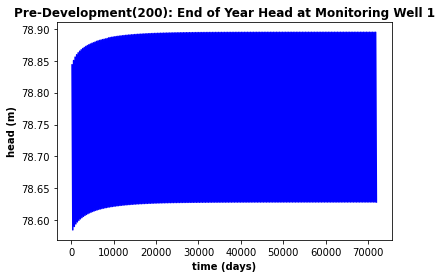

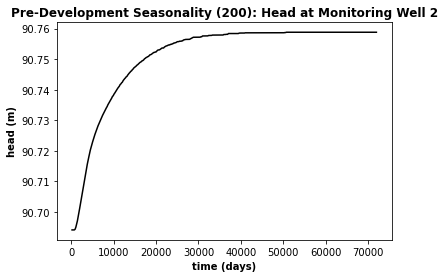

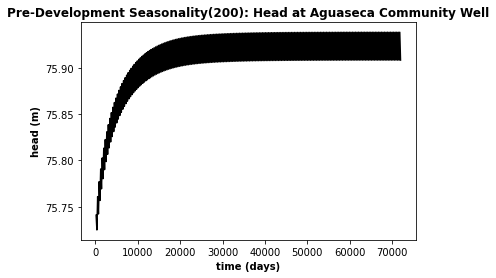

In [39]:
#create plot of MW1
plt.subplot(1, 1, 1)
plt.title("Pre-Development(200): End of Year Head at Monitoring Well 1",fontweight='bold')
plt.xlabel('time (days)',fontweight='bold')
plt.ylabel('head (m)',fontweight='bold')
plt.plot(time_series1[:, 0], time_series1[:, 1], 'b-') #plot the time series with points at each record
plt.show()

#create plot of MW2
plt.subplot(1, 1, 1)
plt.title("Pre-Development Seasonality (200): Head at Monitoring Well 2",fontweight='bold')
plt.xlabel('time (days)',fontweight='bold')
plt.ylabel('head (m)',fontweight='bold')
plt.plot(time_series2[:, 0], time_series2[:, 1], 'k-') #plot the time series with points at each record
plt.show()

# #create plot of Ag well
# plt.subplot(1, 1, 1)
# plt.title("Pre-Development Seasonality: Head at the Irrigation Well",fontweight='bold')
# plt.xlabel('time (days)',fontweight='bold')
# plt.ylabel('head (m)',fontweight='bold')
# plt.plot(time_series_ag[:, 0], time_series_ag[:, 1], 'k-') #plot the time series with points at each record
# plt.show()

#create plot of Aguaseca com well
plt.subplot(1, 1, 1)
plt.title("Pre-Development Seasonality(200): Head at Aguaseca Community Well",fontweight='bold')
plt.xlabel('time (days)',fontweight='bold')
plt.ylabel('head (m)',fontweight='bold')
plt.plot(time_series_agua[:, 0], time_series_agua[:, 1], 'k-') #plot the time series with points at each record
plt.show()

## Getting heads initial and final heads in the wells 

In [38]:
#getting initial heads
print("Initial Head at Monitoring Well 2 = ", head['sp0'][0, 37, 12])
print("Initial Head at Monitoring Well 1 = ", head['sp0'][0, 25, 24])
print("Initial Head at Community Well 1 = ", head['sp0'][2, 29, 37])
print()
#Getting final heads
print("Final Head at Monitoring Well 2 = ", head['sp399'][0, 37, 12])
print("Final Head at Monitoring Well 1 = ", head['sp399'][0, 25, 24])
print("Final Head at Community Well 1 = ", head['sp399'][2, 29, 37])
print()
#other test heads
print("Head at Monitoring Well 2 = ", head['sp398'][0, 37, 12])
print("Head at Monitoring Well 1 = ", head['sp398'][0, 25, 24])
print("Head at Community Well 1 = ", head['sp398'][2, 29, 37])
print()
#other test heads
print("Head at Monitoring Well 2 = ", head['sp397'][0, 37, 12])
print("Head at Monitoring Well 1 = ", head['sp397'][0, 25, 24])
print("Head at Community Well 1 = ", head['sp397'][2, 29, 37])
print()
#other test heads
print("Head at Monitoring Well 2 = ", head['sp396'][0, 37, 12])
print("Head at Monitoring Well 1 = ", head['sp396'][0, 25, 24])
print("Head at Community Well 1 = ", head['sp396'][2, 29, 37])

Initial Head at Monitoring Well 2 =  90.69416
Initial Head at Monitoring Well 1 =  78.84345
Initial Head at Community Well 1 =  75.74093

Final Head at Monitoring Well 2 =  90.758804
Final Head at Monitoring Well 1 =  78.62846
Final Head at Community Well 1 =  75.90845

Head at Monitoring Well 2 =  90.758804
Head at Monitoring Well 1 =  78.89465
Head at Community Well 1 =  75.93851

Head at Monitoring Well 2 =  90.758804
Head at Monitoring Well 1 =  78.62846
Head at Community Well 1 =  75.90845

Head at Monitoring Well 2 =  90.758804
Head at Monitoring Well 1 =  78.89465
Head at Community Well 1 =  75.93851


## Calc and plot river leakage

In [32]:
leakage = budgobj.get_data(text='RIVER LEAKAGE')

#print(len(leakage))
#print(np.shape(leakage))
#print(leakage)

leak=leakage[398]
tot_leak = sum(leak.q)
leak2=leakage[399]
tot_leak2 = sum(leak2.q)
print("Total Daily flux from river to groundwater (Oct-March SP)", tot_leak2, "m3/day")
print("Total Daily flux from river to groundwater (Apr-Sept SP)", tot_leak, "m3/day")

Total Daily flux from river to groundwater (Oct-March SP) 9387.782126426697 m3/day
Total Daily flux from river to groundwater (Apr-Sept SP) 2789.1533081531525 m3/day


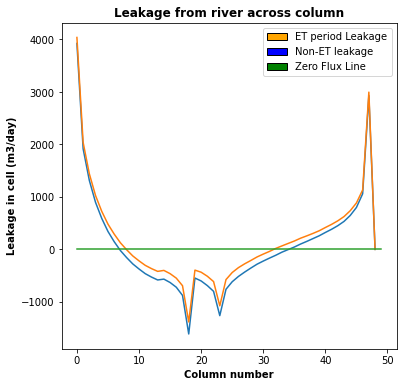

In [36]:
x2 = []
for n in range(0,50):
    x2.append(n)
y2 = np.zeros(50)
fig = plt.figure(figsize=(6, 6))
x = list(range(49))
plt.plot(x, leak.q)
plt.plot(x, leak2.q)
plt.plot(x2, y2)
plt.plot()
plt.title('Leakage from river across column',fontweight='bold')
plt.xlabel('Column number', fontweight = 'bold')
plt.ylabel("Leakage in cell (m3/day)", fontweight = 'bold')
plt.legend(handles=[mp.patches.Patch(color='orange',label='ET period Leakage',ec='black'),
                   mp.patches.Patch(color='blue',label='Non-ET leakage',ec='black'),
                    mp.patches.Patch(color='green',label='Zero Flux Line',ec='black')])
                    
plt.show()

## Saving final head array to start init heads in scen3

In [14]:
from numpy import asarray
from numpy import savetxt
#print(head.keys())

head_top = head['sp399'][0,:,:]
head_mid = head['sp399'][1,:,:]
head_bot = head['sp399'][2,:,:]

savetxt('top_head_spinup_200yr.csv', head_top, delimiter=',')
savetxt('mid_head_spinup_200yr.csv', head_mid, delimiter=',')
savetxt('bot_head_spinup_200yr.csv', head_bot, delimiter=',')

#np.shape(head_top)